### Initiate Notebook

In [1]:
! pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"heatx09","key":"a21497ae78f2c4b750279003221b5a12"}'}

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle competitions download -c iiitb-ga-customer-revenue-prediction -p /content

100% 19.0M/19.1M [00:00<00:00, 87.3MB/s]
100% 19.1M/19.1M [00:00<00:00, 93.5MB/s]
 75% 33.0M/44.3M [00:00<00:00, 46.3MB/s]
100% 44.3M/44.3M [00:00<00:00, 90.1MB/s]
  0% 0.00/5.23M [00:00<?, ?B/s]
100% 5.23M/5.23M [00:00<00:00, 48.0MB/s]


In [6]:
!unzip -u \*.zip 

Archive:  ga_trainV2.csv.zip
  inflating: ga_trainV2.csv          

Archive:  ga_testV2.csv.zip
  inflating: ga_testV2.csv           

Archive:  sample_submissionV2.csv.zip
  inflating: sample_submissionV2.csv  

3 archives were successfully processed.


In [7]:
! find . -name "*.zip" -type f -delete

## Import Libraries

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json 
from datetime import date
from pandas.io.json import json_normalize
from sklearn.model_selection import KFold, StratifiedKFold
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GroupKFold
import gc

%matplotlib inline

# Import Dataset Test and Train

In [9]:
#Split json columns as maincolumn_subcolumn

json_columns = ['device', 'geoNetwork','totals', 'trafficSource']
def load_dataframe(filename):
    #path = "../input/" + filename
    df = pd.read_csv(filename, converters={column: json.loads for column in json_columns}, 
                     dtype={'fullVisitorId': 'str'})
    
    for column in json_columns:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}_{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    return df

In [10]:
#Load Test Dataset
test = load_dataframe("ga_testV2.csv")
test.info()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  # Remove the CWD from sys.path while we load stuff.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271653 entries, 0 to 271652
Data columns (total 54 columns):
 #   Column                                             Non-Null Count   Dtype 
---  ------                                             --------------   ----- 
 0   channelGrouping                                    271653 non-null  object
 1   date                                               271653 non-null  int64 
 2   fullVisitorId                                      271653 non-null  object
 3   sessionId                                          271653 non-null  object
 4   socialEngagementType                               271653 non-null  object
 5   visitId                                            271653 non-null  int64 
 6   visitNumber                                        271653 non-null  int64 
 7   visitStartTime                                     271653 non-null  int64 
 8   device_browser                                     271653 non-null  object
 9   devi

In [11]:
#View Test Dataset
test = pd.DataFrame(test)
test.head(10)

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device_browser,device_browserVersion,device_browserSize,device_operatingSystem,device_operatingSystemVersion,device_isMobile,device_mobileDeviceBranding,device_mobileDeviceModel,device_mobileInputSelector,device_mobileDeviceInfo,device_mobileDeviceMarketingName,device_flashVersion,device_language,device_screenColors,device_screenResolution,device_deviceCategory,geoNetwork_continent,geoNetwork_subContinent,geoNetwork_country,geoNetwork_region,geoNetwork_metro,geoNetwork_city,geoNetwork_cityId,geoNetwork_networkDomain,geoNetwork_latitude,geoNetwork_longitude,geoNetwork_networkLocation,totals_visits,totals_hits,totals_pageviews,totals_bounces,totals_newVisits,totals_transactionRevenue,trafficSource_campaign,trafficSource_source,trafficSource_medium,trafficSource_isTrueDirect,trafficSource_adwordsClickInfo.criteriaParameters,trafficSource_referralPath,trafficSource_keyword,trafficSource_adContent,trafficSource_adwordsClickInfo.page,trafficSource_adwordsClickInfo.slot,trafficSource_adwordsClickInfo.gclId,trafficSource_adwordsClickInfo.adNetworkType,trafficSource_adwordsClickInfo.isVideoAd
0,Direct,20161101,699648481320295572,699648481320295572_1478048916,Not Socially Engaged,1478048916,1,1478048916,Chrome,not available in demo dataset,not available in demo dataset,Linux,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Americas,Northern America,United States,Georgia,Atlanta GA,Atlanta,not available in demo dataset,(not set),not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,1,NaN,(not set),(direct),(none),True,not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Affiliates,20170215,6996488472737499884,6996488472737499884_1487177520,Not Socially Engaged,1487177520,1,1487177520,Chrome,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Europe,Western Europe,Switzerland,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,swisscom.ch,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,11,11,NaN,1,NaN,Data Share Promo,Partners,affiliate,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Social,20161015,699649740746702161,699649740746702161_1476524698,Not Socially Engaged,1476524698,1,1476524698,Safari,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Asia,Southeast Asia,Indonesia,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,unknown.unknown,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,1,NaN,(not set),youtube.com,referral,NaN,not available in demo dataset,/yt/about/,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Organic Search,20170206,6996513200057494074,6996513200057494074_1486424784,Not Socially Engaged,1486424784,1,1486424784,Chrome,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,n

In [12]:
#Load Train Dataset and Viewing
train = load_dataframe("ga_trainV2.csv")
train = pd.DataFrame(train)

#View Train Dataset
train.head(10)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  # Remove the CWD from sys.path while we load stuff.


,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device_browser,device_browserVersion,device_browserSize,device_operatingSystem,device_operatingSystemVersion,device_isMobile,device_mobileDeviceBranding,device_mobileDeviceModel,device_mobileInputSelector,device_mobileDeviceInfo,device_mobileDeviceMarketingName,device_flashVersion,device_language,device_screenColors,device_screenResolution,device_deviceCategory,geoNetwork_continent,geoNetwork_subContinent,geoNetwork_country,geoNetwork_region,geoNetwork_metro,geoNetwork_city,geoNetwork_cityId,geoNetwork_networkDomain,geoNetwork_latitude,geoNetwork_longitude,geoNetwork_networkLocation,totals_visits,totals_hits,totals_pageviews,totals_newVisits,totals_bounces,totals_transactionRevenue,trafficSource_campaign,trafficSource_source,trafficSource_medium,trafficSource_keyword,trafficSource_adwordsClickInfo.criteriaParameters,trafficSource_referralPath,trafficSource_isTrueDirect,trafficSource_adwordsClickInfo.page,trafficSource_adwordsClickInfo.slot,trafficSource_adwordsClickInfo.gclId,trafficSource_adwordsClickInfo.adNetworkType,trafficSource_adwordsClickInfo.isVideoAd,trafficSource_adContent,trafficSource_campaignCode
0,Organic Search,20161020,0000010278554503158,0000010278554503158_1477029466,Not Socially Engaged,1477029466,1,1477029466,Chrome,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Oceania,Australasia,New Zealand,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,xtra.co.nz,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,11,8,1,NaN,NaN,(not set),google,organic,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Organic Search,20161130,0000020424342248747,0000020424342248747_1480578901,Not Socially Engaged,1480578901,1,1480578901,Chrome,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Americas,South America,Peru,Lima Region,(not set),La Victoria,not available in demo dataset,munitrujillo.gob.pe,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,17,13,1,NaN,NaN,(not set),google,organic,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Organic Search,20170211,0000027376579751715,0000027376579751715_1486866293,Not Socially Engaged,1486866293,1,1486866293,Chrome,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Americas,Northern America,United States,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,comcast.net,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,6,5,1,NaN,NaN,(not set),google,organic,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Social,20170327,0000039460501403861,0000039460501403861_1490629516,Not Socially Engaged,1490629516,1,1490629516,Chrome,not available in demo data

In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 632000 entries, 0 to 631999
Data columns (total 55 columns):
 #   Column                                             Non-Null Count   Dtype 
---  ------                                             --------------   ----- 
 0   channelGrouping                                    632000 non-null  object
 1   date                                               632000 non-null  int64 
 2   fullVisitorId                                      632000 non-null  object
 3   sessionId                                          632000 non-null  object
 4   socialEngagementType                               632000 non-null  object
 5   visitId                                            632000 non-null  int64 
 6   visitNumber                                        632000 non-null  int64 
 7   visitStartTime                                     632000 non-null  int64 
 8   device_browser                                     632000 non-null  object
 9   devi

In [14]:
test.info()
# Test Dataset Doesn't have 'trafficSource_campainCode' column

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271653 entries, 0 to 271652
Data columns (total 54 columns):
 #   Column                                             Non-Null Count   Dtype 
---  ------                                             --------------   ----- 
 0   channelGrouping                                    271653 non-null  object
 1   date                                               271653 non-null  int64 
 2   fullVisitorId                                      271653 non-null  object
 3   sessionId                                          271653 non-null  object
 4   socialEngagementType                               271653 non-null  object
 5   visitId                                            271653 non-null  int64 
 6   visitNumber                                        271653 non-null  int64 
 7   visitStartTime                                     271653 non-null  int64 
 8   device_browser                                     271653 non-null  object
 9   devi

## Drop columns not in Test Dataset but are present in Trainning Dataset

In [15]:
unwanted_col = set(train.columns).difference(set(test.columns))
for col in unwanted_col:
  del train[col]
unwanted_col

{'trafficSource_campaignCode'}

In [16]:
print('Test : ',test.shape)
print('Train : ', train.shape)

Test :  (271653, 54)
Train :  (632000, 54)


## Sepreate out numerical and categorical columns

In [17]:
# For Training Dataset 
# Seperate out numerical and object coulmns
numerical_features_train = train.select_dtypes(include = [np.number])
print(numerical_features_train.columns,  numerical_features_train.shape)

Index(['date', 'visitId', 'visitNumber', 'visitStartTime'], dtype='object') (632000, 4)


In [18]:
categorical_features_train = train.select_dtypes(include = [np.object])
print(categorical_features_train.columns,  categorical_features_train.shape)

Index(['channelGrouping', 'fullVisitorId', 'sessionId', 'socialEngagementType',
       'device_browser', 'device_browserVersion', 'device_browserSize',
       'device_operatingSystem', 'device_operatingSystemVersion',
       'device_mobileDeviceBranding', 'device_mobileDeviceModel',
       'device_mobileInputSelector', 'device_mobileDeviceInfo',
       'device_mobileDeviceMarketingName', 'device_flashVersion',
       'device_language', 'device_screenColors', 'device_screenResolution',
       'device_deviceCategory', 'geoNetwork_continent',
       'geoNetwork_subContinent', 'geoNetwork_country', 'geoNetwork_region',
       'geoNetwork_metro', 'geoNetwork_city', 'geoNetwork_cityId',
       'geoNetwork_networkDomain', 'geoNetwork_latitude',
       'geoNetwork_longitude', 'geoNetwork_networkLocation', 'totals_visits',
       'totals_hits', 'totals_pageviews', 'totals_newVisits', 'totals_bounces',
       'totals_transactionRevenue', 'trafficSource_campaign',
       'trafficSource_source', '

In [19]:
#Same  Seperation for Test Dataset
numerical_features_test = test.select_dtypes(include = [np.number])
print(numerical_features_test.columns,  numerical_features_test.shape)


Index(['date', 'visitId', 'visitNumber', 'visitStartTime'], dtype='object') (271653, 4)


In [20]:

categorical_features_test = test.select_dtypes(include = [np.object])
print(categorical_features_test.columns, categorical_features_test.shape)

Index(['channelGrouping', 'fullVisitorId', 'sessionId', 'socialEngagementType',
       'device_browser', 'device_browserVersion', 'device_browserSize',
       'device_operatingSystem', 'device_operatingSystemVersion',
       'device_mobileDeviceBranding', 'device_mobileDeviceModel',
       'device_mobileInputSelector', 'device_mobileDeviceInfo',
       'device_mobileDeviceMarketingName', 'device_flashVersion',
       'device_language', 'device_screenColors', 'device_screenResolution',
       'device_deviceCategory', 'geoNetwork_continent',
       'geoNetwork_subContinent', 'geoNetwork_country', 'geoNetwork_region',
       'geoNetwork_metro', 'geoNetwork_city', 'geoNetwork_cityId',
       'geoNetwork_networkDomain', 'geoNetwork_latitude',
       'geoNetwork_longitude', 'geoNetwork_networkLocation', 'totals_visits',
       'totals_hits', 'totals_pageviews', 'totals_bounces', 'totals_newVisits',
       'totals_transactionRevenue', 'trafficSource_campaign',
       'trafficSource_source', '

## Remove columns which have only one value through out column

In [21]:
# We have some columns which have same value for whole dataset
# Like in geo location we have value "not available in demoset"
# Also if value is common it doesn't contribute anything
# Considering that test dataset also have same conditions

#Removing Const columns
column_names = train.columns.to_list()
columns_with_one_value = []  
#train adCampainCode
for col in column_names:
  count = train[col].nunique(dropna = False)
  if count == 1 and col not in ['totals_bounces', 'totals_hits', 'totals_newVisits']:
    #This column has only one value
    del train[col]
    if col in test.columns.to_list():#For adcampaingcolumn 
      del test[col]
    #Is this need to be done with test
    columns_with_one_value.append(col) 

In [22]:
columns_with_one_value

['socialEngagementType',
 'device_browserVersion',
 'device_browserSize',
 'device_operatingSystemVersion',
 'device_mobileDeviceBranding',
 'device_mobileDeviceModel',
 'device_mobileInputSelector',
 'device_mobileDeviceInfo',
 'device_mobileDeviceMarketingName',
 'device_flashVersion',
 'device_language',
 'device_screenColors',
 'device_screenResolution',
 'geoNetwork_cityId',
 'geoNetwork_latitude',
 'geoNetwork_longitude',
 'geoNetwork_networkLocation',
 'totals_visits',
 'trafficSource_adwordsClickInfo.criteriaParameters']

In [23]:
print(test.shape, train.shape)

(271653, 35) (632000, 35)


In [24]:
train.columns

Index(['channelGrouping', 'date', 'fullVisitorId', 'sessionId', 'visitId',
       'visitNumber', 'visitStartTime', 'device_browser',
       'device_operatingSystem', 'device_isMobile', 'device_deviceCategory',
       'geoNetwork_continent', 'geoNetwork_subContinent', 'geoNetwork_country',
       'geoNetwork_region', 'geoNetwork_metro', 'geoNetwork_city',
       'geoNetwork_networkDomain', 'totals_hits', 'totals_pageviews',
       'totals_newVisits', 'totals_bounces', 'totals_transactionRevenue',
       'trafficSource_campaign', 'trafficSource_source',
       'trafficSource_medium', 'trafficSource_keyword',
       'trafficSource_referralPath', 'trafficSource_isTrueDirect',
       'trafficSource_adwordsClickInfo.page',
       'trafficSource_adwordsClickInfo.slot',
       'trafficSource_adwordsClickInfo.gclId',
       'trafficSource_adwordsClickInfo.adNetworkType',
       'trafficSource_adwordsClickInfo.isVideoAd', 'trafficSource_adContent'],
      dtype='object')

In [25]:
test.columns

Index(['channelGrouping', 'date', 'fullVisitorId', 'sessionId', 'visitId',
       'visitNumber', 'visitStartTime', 'device_browser',
       'device_operatingSystem', 'device_isMobile', 'device_deviceCategory',
       'geoNetwork_continent', 'geoNetwork_subContinent', 'geoNetwork_country',
       'geoNetwork_region', 'geoNetwork_metro', 'geoNetwork_city',
       'geoNetwork_networkDomain', 'totals_hits', 'totals_pageviews',
       'totals_bounces', 'totals_newVisits', 'totals_transactionRevenue',
       'trafficSource_campaign', 'trafficSource_source',
       'trafficSource_medium', 'trafficSource_isTrueDirect',
       'trafficSource_referralPath', 'trafficSource_keyword',
       'trafficSource_adContent', 'trafficSource_adwordsClickInfo.page',
       'trafficSource_adwordsClickInfo.slot',
       'trafficSource_adwordsClickInfo.gclId',
       'trafficSource_adwordsClickInfo.adNetworkType',
       'trafficSource_adwordsClickInfo.isVideoAd'],
      dtype='object')

## Find columns which have missing values and their percentage

In [26]:
#Lets start with missing value treatment then move on to Exploratory analysis Analysis
#First for categorical features
#For Train 
all_missing_value_test = categorical_features_train.isnull().sum().sort_values(ascending = False)
#Calculating percentage
percent = (categorical_features_train.isnull().sum() / categorical_features_train.isnull().count()).sort_values(ascending = False) * 100
missing_data = pd.concat([all_missing_value_test, percent], axis=1,join='outer', keys=['Total Missing Count', ' % of Total Observations'])
missing_data.index.name ='Feature'
missing_data.head(15)
#NoT taking eda of test as it is similar to train

,Total Missing Count,% of Total Observations
Feature,,
trafficSource_adContent,624199,98.765665
totals_transactionRevenue,623895,98.717563
trafficSource_adwordsClickInfo.adNetworkType,616866,97.605380
trafficSource_adwordsClickInfo.slot,616866,97.605380
trafficSource_adwordsClickInfo.page,616866,97.605380
trafficSource_adwordsClickInfo.isVideoAd,616866,97.605380
trafficSource_adwordsClickInfo.gclId,616791,97.593513
trafficSource_isTrueDirect,440213,69.653956
trafficSource_referralPath,400735,63.407437


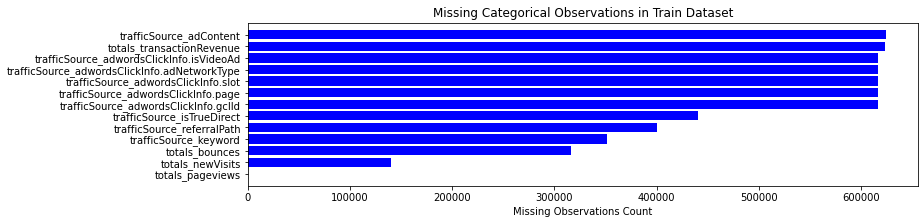

In [27]:
#Visualizing
missing_values = categorical_features_train.isnull().sum(axis=0).reset_index()
missing_values.columns = ['column_name', 'missing_count']
missing_values = missing_values.loc[missing_values['missing_count']>0]
missing_values = missing_values.sort_values(by='missing_count')
indx = np.arange(missing_values.shape[0])
width = 0.2
fig, ax = plt.subplots(figsize=(12,3))
rects = ax.barh(indx, missing_values.missing_count.values, color='b')
ax.set_yticks(indx)
ax.set_yticklabels(missing_values.column_name.values, rotation='horizontal')
ax.set_xlabel("Missing Observations Count")
ax.set_title("Missing Categorical Observations in Train Dataset")
plt.show()

In [28]:
#for col in train.columns:
 # print(col, train[col].unique())


All Columns Treatment one by one

# Exploratory data analysis of each column

## Revenue Generating Customers

In [29]:
train["totals_transactionRevenue"] = train["totals_transactionRevenue"].astype('float')
gdf = train.groupby("fullVisitorId")["totals_transactionRevenue"].sum().reset_index()

nzc = pd.notnull(train["totals_transactionRevenue"]).sum()
nzr = (gdf["totals_transactionRevenue"]>0).sum()
print("Number of customers in train set with non-zero revenue : ", nzc, " and ratio is : ", nzc / train.shape[0])
print("Number of unique customers with non-zero revenue : ", nzr, "and the ratio is : ", nzr / gdf.shape[0])

Number of customers in train set with non-zero revenue :  8105  and ratio is :  0.012824367088607595
Number of unique customers with non-zero revenue :  7050 and the ratio is :  0.014118127675935902


## Number of Customers common in both Training and Test Set

In [30]:
print("Number of unique visitors in train set : ",train.fullVisitorId.nunique(), " out of rows : ",train.shape[0])
print("Number of unique visitors in test set : ",test.fullVisitorId.nunique(), " out of rows : ",test.shape[0])
print("Number of common visitors in train and test set : ",len(set(train.fullVisitorId.unique()).intersection(set(test.fullVisitorId.unique())) ))


Number of unique visitors in train set :  499358  out of rows :  632000
Number of unique visitors in test set :  214809  out of rows :  271653
Number of common visitors in train and test set :  0


So we are dealing with completely new customers

## Fill null tansaction value with 0

In [31]:
#Fill total transaction revenue of null as 0
train['totals_transactionRevenue'] = train['totals_transactionRevenue'].fillna(0)
test['totals_transactionRevenue'] = test['totals_transactionRevenue'].fillna(0)

## Target Feature Analysis

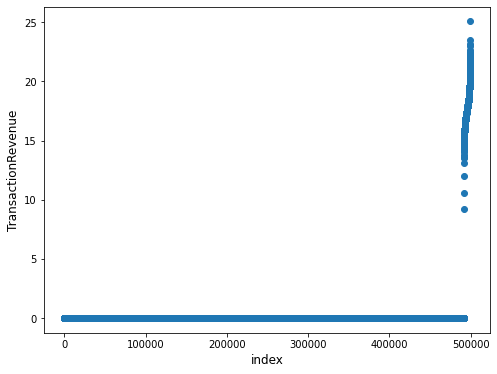

In [32]:
train["totals_transactionRevenue"] = train["totals_transactionRevenue"].astype('float')
gdf = train.groupby("fullVisitorId")["totals_transactionRevenue"].sum().reset_index()

plt.figure(figsize=(8,6))
#plt.hist( gdf["totals.transactionRevenue"].values)
plt.scatter(range(gdf.shape[0]), np.sort(np.log1p(gdf["totals_transactionRevenue"].values)))
plt.xlabel('index', fontsize=12)
plt.ylabel('TransactionRevenue', fontsize=12)
plt.show()

So we are dealing with completely skewded data.
As the description says we have 20% revenue generating customers

## Date and VisitStartTime

In [33]:
#library of datetime
from datetime import datetime

# This function is to extract date features
def date_process(df):
    df["date"] = pd.to_datetime(df["date"], format="%Y%m%d") # seting the column as pandas datetime
    df["_weekday"] = df['date'].dt.dayofweek #extracting week day
    df["_day"] = df['date'].dt.day # extracting day
    df["_month"] = df['date'].dt.month # extracting month
    df["_year"] = df['date'].dt.year # extracting year
    df['_visitHour'] = (df['visitStartTime'].apply(lambda x: str(datetime.fromtimestamp(x).hour))).astype(int)
    return df #returning the df after the transformations

In [34]:
train.head(10)

,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,device_browser,device_operatingSystem,device_isMobile,device_deviceCategory,geoNetwork_continent,geoNetwork_subContinent,geoNetwork_country,geoNetwork_region,geoNetwork_metro,geoNetwork_city,geoNetwork_networkDomain,totals_hits,totals_pageviews,totals_newVisits,totals_bounces,totals_transactionRevenue,trafficSource_campaign,trafficSource_source,trafficSource_medium,trafficSource_keyword,trafficSource_referralPath,trafficSource_isTrueDirect,trafficSource_adwordsClickInfo.page,trafficSource_adwordsClickInfo.slot,trafficSource_adwordsClickInfo.gclId,trafficSource_adwordsClickInfo.adNetworkType,trafficSource_adwordsClickInfo.isVideoAd,trafficSource_adContent
0,Organic Search,20161020,0000010278554503158,0000010278554503158_1477029466,1477029466,1,1477029466,Chrome,Macintosh,False,desktop,Oceania,Australasia,New Zealand,not available in demo dataset,not available in demo dataset,not available in demo dataset,xtra.co.nz,11,8,1,NaN,0.0,(not set),google,organic,(not provided),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Organic Search,20161130,0000020424342248747,0000020424342248747_1480578901,1480578901,1,1480578901,Chrome,Windows,False,desktop,Americas,South America,Peru,Lima Region,(not set),La Victoria,munitrujillo.gob.pe,17,13,1,NaN,0.0,(not set),google,organic,(not provided),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Organic Search,20170211,0000027376579751715,0000027376579751715_1486866293,1486866293,1,1486866293,Chrome,Macintosh,False,desktop,Americas,Northern America,United States,not available in demo dataset,not available in demo dataset,not available in demo dataset,comcast.net,6,5,1,NaN,0.0,(not set),google,organic,(not provided),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Social,20170327,0000039460501403861,0000039460501403861_1490629516,1490629516,1,1490629516,Chrome,Windows,False,desktop,Americas,South America,Brazil,not available in demo dataset,not available in demo dataset,not available in demo dataset,virtua.com.br,2,2,1,NaN,0.0,(not set),youtube.com,referral,NaN,/yt/about/pt-BR/,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Paid Search,20170211,0000040862739425590,0000040862739425590_1486838824,1486838824,2,1486838824,Chrome,Macintosh,False,desktop,Americas,Northern America,United States,California,San Francisco-Oakland-San Jose CA,Oakland,comcastbusiness.net,3,3,NaN,NaN,0.0,AW - Dynamic Search Ads Whole Site,google,cpc,1hZbAqLCbjwfgOH7,NaN,True,1,Top,Cj0KEQiAifvEBRCVx5up6Ojgr5oBEiQALHw1TrnWAHiMtZ...,Google Search,False,NaN
5,Paid Search,20170211,0000040862739425590,0000040862739425590_1486836571,1486836571,1,1486836571,Chrome,Macintosh,False,desktop,Americas,Northern America,United States,California,San Francisco-Oakland-San Jose CA,Oakland,comcastbusiness.net,2,2,1,NaN,0.0,AW - Dynamic Search Ads Whole Site,google,cpc,1hZbAqLCbjwfgOH7,NaN,NaN,1,Top,Cj0KEQiAifvEBRCVx5up6Ojgr5oBEiQALHw1TrnWAHiMtZ...,Google Search,False,NaN
6,Organic Search,20160821,000005103959234087,000005103959234087_1471817208,1471817208,1,1471817208,Chrome,Android,True,mobile,Americas,Northern America,United States,not available in demo dataset,not available in demo dataset,not available in demo dataset,comcast.net,10,8,1,NaN,0.0,(not set),google,organic,(not provided),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Affiliates,20170709,0000062267706107999,0000062267706107999_1499645960,1499645960,1,1499645960,Chrome,Windows,False,desktop,Americas,South America,Brazil,not available in demo dataset,not available in demo dataset,not available in demo dataset,unknown.unknown,1,1,1,1,0.0,Data Share Promo,Partners,affiliate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Organic Search,20170403,0000068403966359845,0000068403966359845_1491281649,1491281649,1,1491281649,Safari,iOS,True,tablet,Americas,Northern America,United States,California,Los Angeles CA,Los Angeles,aerioconnect.net,2,2,1,NaN,0.0,(not set),google,organic,(not provided),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Direct,20170719,0000085059828173212,0000085059828173212_1500505105,15

In [35]:
train_date = date_process(train)
test_date = date_process(test)

In [36]:
train_date.head(100000)

,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,device_browser,device_operatingSystem,device_isMobile,device_deviceCategory,geoNetwork_continent,geoNetwork_subContinent,geoNetwork_country,geoNetwork_region,geoNetwork_metro,geoNetwork_city,geoNetwork_networkDomain,totals_hits,totals_pageviews,totals_newVisits,totals_bounces,totals_transactionRevenue,trafficSource_campaign,trafficSource_source,trafficSource_medium,trafficSource_keyword,trafficSource_referralPath,trafficSource_isTrueDirect,trafficSource_adwordsClickInfo.page,trafficSource_adwordsClickInfo.slot,trafficSource_adwordsClickInfo.gclId,trafficSource_adwordsClickInfo.adNetworkType,trafficSource_adwordsClickInfo.isVideoAd,trafficSource_adContent,_weekday,_day,_month,_year,_visitHour
0,Organic Search,2016-10-20,0000010278554503158,0000010278554503158_1477029466,1477029466,1,1477029466,Chrome,Macintosh,False,desktop,Oceania,Australasia,New Zealand,not available in demo dataset,not available in demo dataset,not available in demo dataset,xtra.co.nz,11,8,1,NaN,0.0,(not set),google,organic,(not provided),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,20,10,2016,5
1,Organic Search,2016-11-30,0000020424342248747,0000020424342248747_1480578901,1480578901,1,1480578901,Chrome,Windows,False,desktop,Americas,South America,Peru,Lima Region,(not set),La Victoria,munitrujillo.gob.pe,17,13,1,NaN,0.0,(not set),google,organic,(not provided),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,30,11,2016,7
2,Organic Search,2017-02-11,0000027376579751715,0000027376579751715_1486866293,1486866293,1,1486866293,Chrome,Macintosh,False,desktop,Americas,Northern America,United States,not available in demo dataset,not available in demo dataset,not available in demo dataset,comcast.net,6,5,1,NaN,0.0,(not set),google,organic,(not provided),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,11,2,2017,2
3,Social,2017-03-27,0000039460501403861,0000039460501403861_1490629516,1490629516,1,1490629516,Chrome,Windows,False,desktop,Americas,South America,Brazil,not available in demo dataset,not available in demo dataset,not available in demo dataset,virtua.com.br,2,2,1,NaN,0.0,(not set),youtube.com,referral,NaN,/yt/about/pt-BR/,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,27,3,2017,15
4,Paid Search,2017-02-11,0000040862739425590,0000040862739425590_1486838824,1486838824,2,1486838824,Chrome,Macintosh,False,desktop,Americas,Northern America,United States,California,San Francisco-Oakland-San Jose CA,Oakland,comcastbusiness.net,3,3,NaN,NaN,0.0,AW - Dynamic Search Ads Whole Site,google,cpc,1hZbAqLCbjwfgOH7,NaN,True,1,Top,Cj0KEQiAifvEBRCVx5up6Ojgr5oBEiQALHw1TrnWAHiMtZ...,Google Search,False,NaN,5,11,2,2017,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,Direct,2017-04-01,1111109381520062641,1111109381520062641_1491037127,1491037127,1,1491037127,Safari,Macintosh,False,desktop,Americas,Northern America,United States,(not set),(not set),(not set),(not set),1,1,1,1,0.0,(not set),(direct),(none),NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,5,1,4,2017,8
99996,Organic Search,2017-02-23,1111114849059170476,1111114849059170476_1487891330,1487891330,1,1487891330,Safari,iOS,True,mobile,Europe,Northern Europe,United Kingdom,not available in demo dataset,not available in demo dataset,not available in demo dataset,(not set),3,3,1,NaN,0.0,(not set),google,organic,(not provided),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,23,2,2017,23
99997,Social,2016-11-11,1111116601227299267,1111116601227299267_1478891606,1478891606,1,1478891606,Chrome,Windows,False,desktop,Europe,Eastern Europe,Bulgaria,Sofia City Province,(not set),Sofia,unknown.unknown,2,2,1,NaN,0.0,(not set),youtube.com,referral,NaN,/yt/about/,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,11,11,2016,19
99998,Social,2016-09-28,1111159454602373378,1111159454602373378_1475048157,1475048157,1,1475048157,Safari,Macintosh,False,desktop,Asia,Southeast Asia,Vietnam,not available in demo dataset,not available in demo datase

### Exploring Date Field 

In [37]:
#convert total_transaction revenue to 'float64' from  'object'
train_date = train_date.astype({'totals_transactionRevenue': 'float64'}, copy = True)
test_date = test_date.astype({'totals_transactionRevenue': 'float64'}, copy = True)

In [38]:
train_date.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 632000 entries, 0 to 631999
Data columns (total 40 columns):
 #   Column                                        Non-Null Count   Dtype         
---  ------                                        --------------   -----         
 0   channelGrouping                               632000 non-null  object        
 1   date                                          632000 non-null  datetime64[ns]
 2   fullVisitorId                                 632000 non-null  object        
 3   sessionId                                     632000 non-null  object        
 4   visitId                                       632000 non-null  int64         
 5   visitNumber                                   632000 non-null  int64         
 6   visitStartTime                                632000 non-null  int64         
 7   device_browser                                632000 non-null  object        
 8   device_operatingSystem                        632000 n

In [39]:
train_date.head()

,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,device_browser,device_operatingSystem,device_isMobile,device_deviceCategory,geoNetwork_continent,geoNetwork_subContinent,geoNetwork_country,geoNetwork_region,geoNetwork_metro,geoNetwork_city,geoNetwork_networkDomain,totals_hits,totals_pageviews,totals_newVisits,totals_bounces,totals_transactionRevenue,trafficSource_campaign,trafficSource_source,trafficSource_medium,trafficSource_keyword,trafficSource_referralPath,trafficSource_isTrueDirect,trafficSource_adwordsClickInfo.page,trafficSource_adwordsClickInfo.slot,trafficSource_adwordsClickInfo.gclId,trafficSource_adwordsClickInfo.adNetworkType,trafficSource_adwordsClickInfo.isVideoAd,trafficSource_adContent,_weekday,_day,_month,_year,_visitHour
0,Organic Search,2016-10-20,0000010278554503158,0000010278554503158_1477029466,1477029466,1,1477029466,Chrome,Macintosh,False,desktop,Oceania,Australasia,New Zealand,not available in demo dataset,not available in demo dataset,not available in demo dataset,xtra.co.nz,11,8,1,NaN,0.0,(not set),google,organic,(not provided),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,20,10,2016,5
1,Organic Search,2016-11-30,0000020424342248747,0000020424342248747_1480578901,1480578901,1,1480578901,Chrome,Windows,False,desktop,Americas,South America,Peru,Lima Region,(not set),La Victoria,munitrujillo.gob.pe,17,13,1,NaN,0.0,(not set),google,organic,(not provided),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,30,11,2016,7
2,Organic Search,2017-02-11,0000027376579751715,0000027376579751715_1486866293,1486866293,1,1486866293,Chrome,Macintosh,False,desktop,Americas,Northern America,United States,not available in demo dataset,not available in demo dataset,not available in demo dataset,comcast.net,6,5,1,NaN,0.0,(not set),google,organic,(not provided),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,11,2,2017,2
3,Social,2017-03-27,0000039460501403861,0000039460501403861_1490629516,1490629516,1,1490629516,Chrome,Windows,False,desktop,Americas,South America,Brazil,not available in demo dataset,not available in demo dataset,not available in demo dataset,virtua.com.br,2,2,1,NaN,0.0,(not set),youtube.com,referral,NaN,/yt/about/pt-BR/,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,27,3,2017,15
4,Paid Search,2017-02-11,0000040862739425590,0000040862739425590_1486838824,1486838824,2,1486838824,Chrome,Macintosh,False,desktop,Americas,Northern America,United States,California,San Francisco-Oakland-San Jose CA,Oakland,comcastbusiness.net,3,3,NaN,NaN,0.0,AW - Dynamic Search Ads Whole Site,google,cpc,1hZbAqLCbjwfgOH7,NaN,True,1,Top,Cj0KEQiAifvEBRCVx5up6Ojgr5oBEiQALHw1TrnWAHiMtZ...,Google Search,False,NaN,5,11,2,2017,18


### Check impack of Visit Hour or time of visit on Transaction Revenue

<BarContainer object of 24 artists>

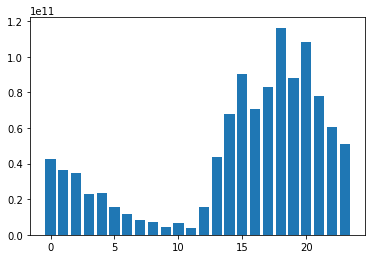

In [40]:
grpbyvisitHour = train_date.groupby('_visitHour')
revenue = dict(grpbyvisitHour['totals_transactionRevenue'].sum())
plt.bar(revenue.keys() , revenue.values())

This clearly shows there is more sales during from 14 to 23 hrs

### Impact of Weekday

<BarContainer object of 7 artists>

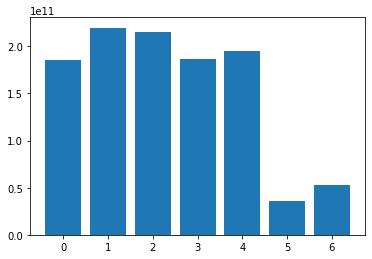

In [41]:
grpbyweek = train_date.groupby('_weekday')
revenue = dict(grpbyweek['totals_transactionRevenue'].sum())
plt.bar(revenue.keys() , revenue.values())

On weekends Sales is less while on weekdays it is more

### Lets analyze revenue on 'day' basis

<BarContainer object of 31 artists>

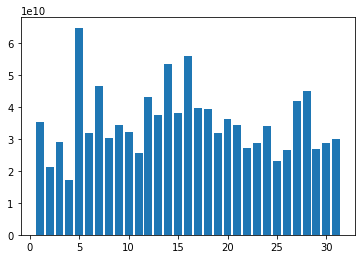

In [42]:
grpbyday = train_date.groupby('_day')
revenue = dict(grpbyday['totals_transactionRevenue'].sum())
plt.bar(revenue.keys() , revenue.values())

There doesnt seem much dependence on day. but a bit can be said that during month ends sales get stable while there is both in moth start

### Lets analyze on 'month' basis

<BarContainer object of 12 artists>

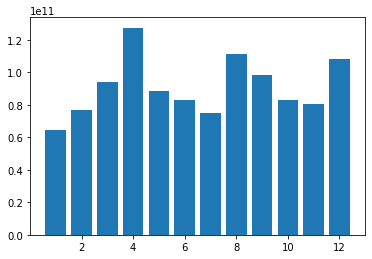

In [43]:
grpbymonth = train_date.groupby('_month')
revenue = dict(grpbymonth['totals_transactionRevenue'].sum())
plt.bar(revenue.keys() , revenue.values())

Things seems similar for month. Just during year end sales increase a bit

Check for 'Year'

<BarContainer object of 2 artists>

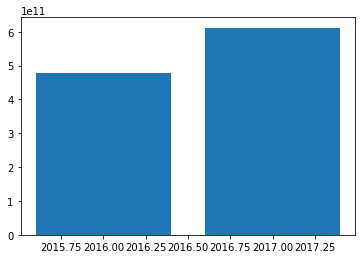

In [44]:
grpbyyear = train_date.groupby('_year')
revenue = dict(grpbyyear['totals_transactionRevenue'].sum())
plt.bar(revenue.keys() , revenue.values())

We can keep this rise 

In [45]:
print(train_date['date'].min(), train_date['date'].max())

2016-08-01 00:00:00 2017-08-01 00:00:00


In [46]:
train_date['date'].describe()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


count                  632000
unique                    366
top       2016-11-28 00:00:00
freq                     3337
first     2016-08-01 00:00:00
last      2017-08-01 00:00:00
Name: date, dtype: object

In [47]:
print(test_date['date'].min(), test_date['date'].max())

2016-08-01 00:00:00 2017-08-01 00:00:00


In [48]:
test_date['date'].describe()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


count                  271653
unique                    366
top       2016-11-28 00:00:00
freq                     1470
first     2016-08-01 00:00:00
last      2017-08-01 00:00:00
Name: date, dtype: object

So in both of our datasets will have same date range

### Date vs Total revenue

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


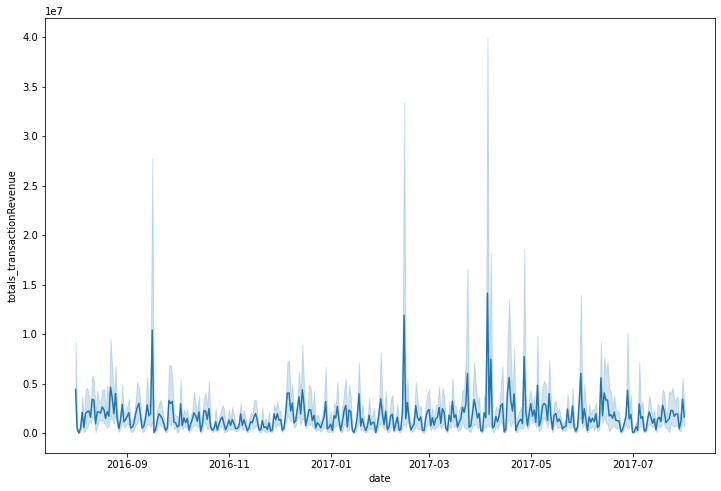

In [49]:
#Train Dataset
plt.figure(figsize=(12, 8))
sns.lineplot(train_date['date'], train_date['totals_transactionRevenue'])

We can see on some days, there is **Sale Spike** alot Like in November-2016, February end - March-2017, April 2017 




### Date vs userCounts in train set

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


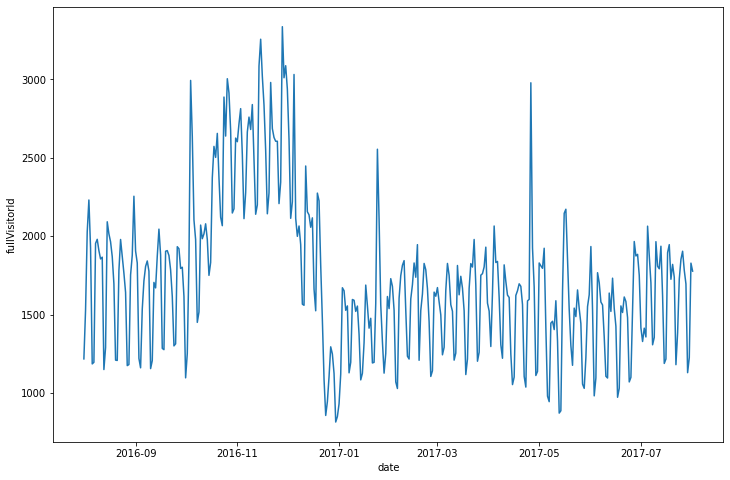

In [50]:
cnt_urs = train_date.groupby('date')['fullVisitorId'].size().reset_index()
plt.figure(figsize=(12, 8))
sns.lineplot(cnt_urs['date'], cnt_urs['fullVisitorId'])

As we can see During November December 2016, and during May 2017 user mostly visit Google store.

## Analysis of Channel Grouping

In [51]:
print('channelGrouping values')
print(train['channelGrouping'].unique())

channelGrouping values
['Organic Search' 'Social' 'Paid Search' 'Affiliates' 'Direct' 'Referral'
 'Display' '(Other)']


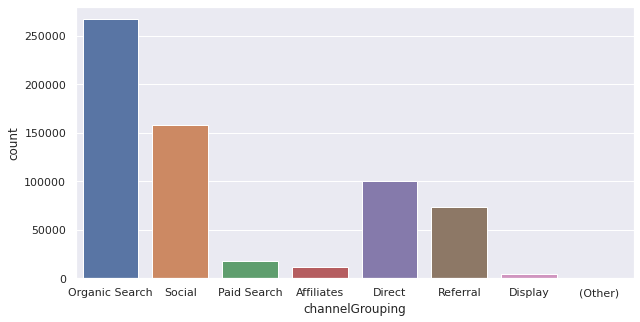

In [52]:
%matplotlib inline
plt.figure(figsize=(10,5))
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="channelGrouping", data=train)

<BarContainer object of 8 artists>

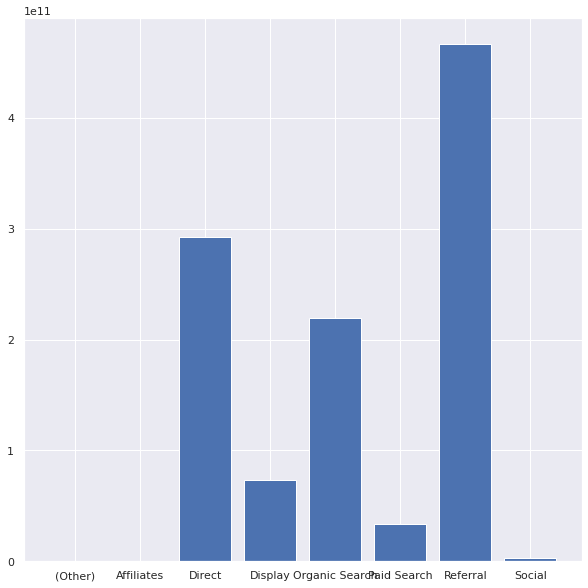

In [53]:
grpbychannel = train_date.groupby('channelGrouping')
revenue = dict(grpbychannel['totals_transactionRevenue'].sum())
plt.figure(figsize= (10,10))
plt.bar(revenue.keys() , revenue.values())

## Function to extract column specific category

In [54]:
import re
def columns_extract(category):
    cat_cols = list()
    for i in train_date.columns: 
        a = re.findall(r'^'+category+'.*',i)
        if a:
            cat_cols.append(a[0])
        else:
            continue
    return cat_cols

In [55]:
'''
Function to plot 4 types of barplots for each categorical column
1) Categories vs their counts
2) Categories vs Non-Zero Revenue
3) Categories vs Mean Transaction Revenue
4) Categories vs Total Reveue
'''
def category_plots(col):
    a = train_date.loc[:,[col, 'totals_transactionRevenue']]
    a['totals_transactionRevenue'] = a['totals_transactionRevenue'].replace(0.0, np.nan)
    #a['totals_transactionRevenue'] = a['totals_transactionRevenue'].apply(np.expm1)
    cnt_srs = a.groupby(col)['totals_transactionRevenue'].agg(['size','count','mean'])
    cnt_srs.columns = ["count", 'count_of_non-zero_revenue', "mean_transaction_value"]

    cnt_srs['total_revenue'] = cnt_srs['count_of_non-zero_revenue']*cnt_srs['mean_transaction_value']
    cnt_srs = cnt_srs.sort_values(by="mean_transaction_value", ascending=False)
    print(cnt_srs.head(10))
    plt.figure(figsize=(8, 20)) 
    plt.subplot(4,1,1)
    sns.barplot(x=cnt_srs['count'].head(10), y=cnt_srs.index[:10])
    plt.subplot(4,1,2)
    sns.barplot(x=cnt_srs['count_of_non-zero_revenue'].head(10), y=cnt_srs.index[:10])
    plt.subplot(4,1,3)
    sns.barplot(x=cnt_srs['mean_transaction_value'].head(10), y=cnt_srs.index[:10])
    plt.subplot(4,1,4)
    sns.barplot(x=cnt_srs['total_revenue'].head(10), y=cnt_srs.index[:10])

#cnt_srs

## Lets Explore Device column and sub columns

In [56]:
device_columns = columns_extract('device')

In [57]:
train_date[device_columns].nunique(dropna = False)

device_browser            49
device_operatingSystem    17
device_isMobile            2
device_deviceCategory      3
dtype: int64

### Device Browser

                    count  ...  total_revenue
device_browser             ...               
Firefox             25994  ...   8.579276e+10
Edge                 7039  ...   6.043310e+09
Chrome             434036  ...   9.608052e+11
Safari             127336  ...   3.293614e+10
Internet Explorer   13623  ...   4.206670e+09
Opera                3963  ...   1.774300e+08
Amazon Silk           402  ...   2.999000e+07
Android Webview      5422  ...   1.008700e+08
Safari (in-app)      4838  ...   1.148000e+08
(not set)               5  ...            NaN

[10 rows x 4 columns]


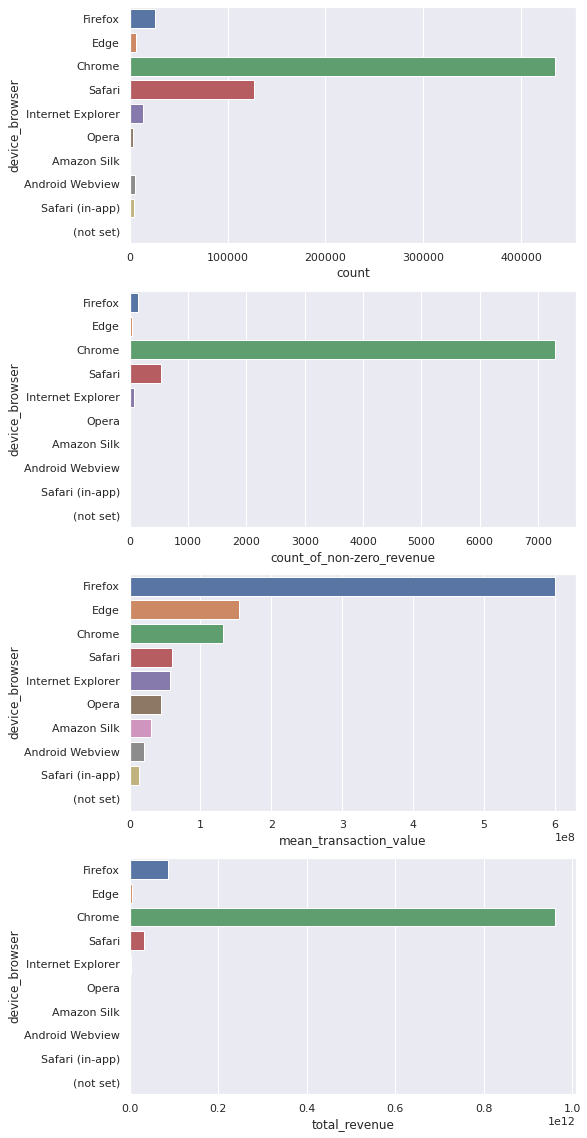

In [58]:
%matplotlib inline
category_plots('device_browser')

In [59]:
train_date['device_browser'].unique()

array(['Chrome', 'Safari', 'Android Webview', 'Internet Explorer',
       'Opera Mini', 'YaBrowser', 'Firefox', 'Edge', 'Coc Coc', 'Opera',
       'Iron', 'Puffin', 'Safari (in-app)', 'UC Browser',
       'Nintendo Browser', 'Mozilla Compatible Agent', 'Amazon Silk',
       'Nokia Browser', 'Android Browser', 'MRCHROME', 'BlackBerry',
       'Maxthon', 'LYF_LS_4002_11', 'Nichrome', 'User Agent', 'SeaMonkey',
       '(not set)', 'ThumbSniper', 'Seznam', 'Apple-iPhone7C2',
       'MQQBrowser', 'osee2unifiedRelease', 'LYF_LS_4002_12', 'YE',
       'Mozilla', 'Android Runtime', 'HTC802t_TD', 'DASH_JR_3G', 'M5',
       'Lunascape', 'Reddit', 'NokiaE52-1', 'CSM Click', 'Konqueror', '0',
       '[Use default User-agent string] LIVRENPOCHE', 'no-ua', 'ADM',
       'Changa 99695759'], dtype=object)

In [60]:
'''
Function to reduce categorical values in browser: Here we are keeping only popular browsers abd merging some not much known browsers
'''
def popular_browser(x):
    browsers = ['chrome','safari','firefox','internet explorer','edge','opera', 'opera mini','uc browser', 'coc coc','iron', 
                'android webview', 'safari (in-app)', 'puffin', 'yabrowser', 'amazon silk' ]
    if x in browsers:
        return x.lower()
    elif 'android' in x:
      return 'android'
    elif 'browser' in x:
      return 'browser'
    elif 'mozilla' in x:
      return 'mozilla'  
    elif 'chrome' in x:
      return 'dupchrome'
    elif 'nokia' in x:
      return 'nokia'
    elif '(not set)' in x or 'nan' in x:
        return x
    else:
        return 'unpopular_browser'

In [61]:
#Keeping popular browsers in both Test and Train dataset
train_date['device_browser'] = train_date['device_browser'].apply(lambda x: popular_browser(str(x).lower()))
test_date['device_browser'] = test_date['device_browser'].apply(lambda x: popular_browser(str(x).lower()))

In [62]:
train_date['device_browser'].nunique()

22

In [63]:
train_date['device_browser'].unique()

array(['chrome', 'safari', 'android webview', 'internet explorer',
       'opera mini', 'yabrowser', 'firefox', 'edge', 'coc coc', 'opera',
       'iron', 'puffin', 'safari (in-app)', 'uc browser', 'browser',
       'mozilla', 'amazon silk', 'android', 'dupchrome',
       'unpopular_browser', '(not set)', 'nokia'], dtype=object)

### Work on Device operating system

In [64]:
train_date['device_operatingSystem'].unique()

array(['Macintosh', 'Windows', 'Android', 'iOS', 'Linux', '(not set)',
       'Chrome OS', 'Windows Phone', 'Samsung', 'Xbox', 'Nintendo WiiU',
       'BlackBerry', 'Firefox OS', 'Nintendo Wii', 'FreeBSD',
       'Nintendo 3DS', 'Nokia'], dtype=object)

                         count  ...  total_revenue
device_operatingSystem          ...               
Chrome OS                18702  ...   1.285882e+11
Windows                 244412  ...   2.839914e+11
Macintosh               177916  ...   6.111477e+11
Android                  86348  ...   2.052110e+10
Linux                    24700  ...   3.013849e+10
iOS                      75269  ...   1.582028e+10
(not set)                 3300  ...            NaN
BlackBerry                 164  ...            NaN
Firefox OS                  60  ...            NaN
FreeBSD                      4  ...            NaN

[10 rows x 4 columns]


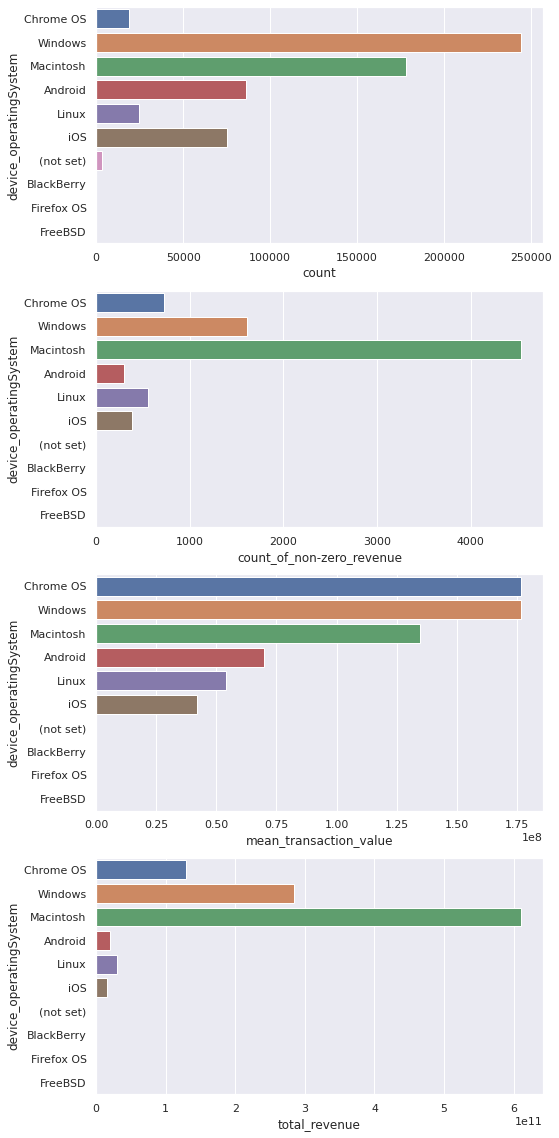

In [65]:
category_plots('device_operatingSystem')

In [66]:
'''
Function to reduce categorical values in Oprating System: Here we are keeping only popular browsers abd merging some not much known browsers
'''
def popular_OS(x):
    OS = ['Macintosh', 'Windows', 'Android', 'iOS', 'Linux', 'Chrome OS','windows phone', 'Samsung', 'Xbox']
    if x in OS:
        return x.lower()
    elif 'Nintendo' in x:
      return 'Nintendo'
    elif '(not set)' in x or 'nan' in x:
        return x
    else:
        return 'unpopular_OS'

In [67]:
# Make Changes in both Train and Test Dataset
train_date['device_operatingSystem'] = train_date['device_operatingSystem'].apply(lambda x: popular_OS(x))
test_date['device_operatingSystem'] = test_date['device_operatingSystem'].apply(lambda x: popular_OS(x))

In [68]:
train_date['device_operatingSystem'].unique()

array(['macintosh', 'windows', 'android', 'ios', 'linux', '(not set)',
       'chrome os', 'unpopular_OS', 'samsung', 'xbox', 'Nintendo'],
      dtype=object)

### Work on device category

                        count  ...  total_revenue
device_deviceCategory          ...               
desktop                465104  ...   1.053322e+12
tablet                  21381  ...   6.292370e+09
mobile                 145515  ...   3.059276e+10

[3 rows x 4 columns]


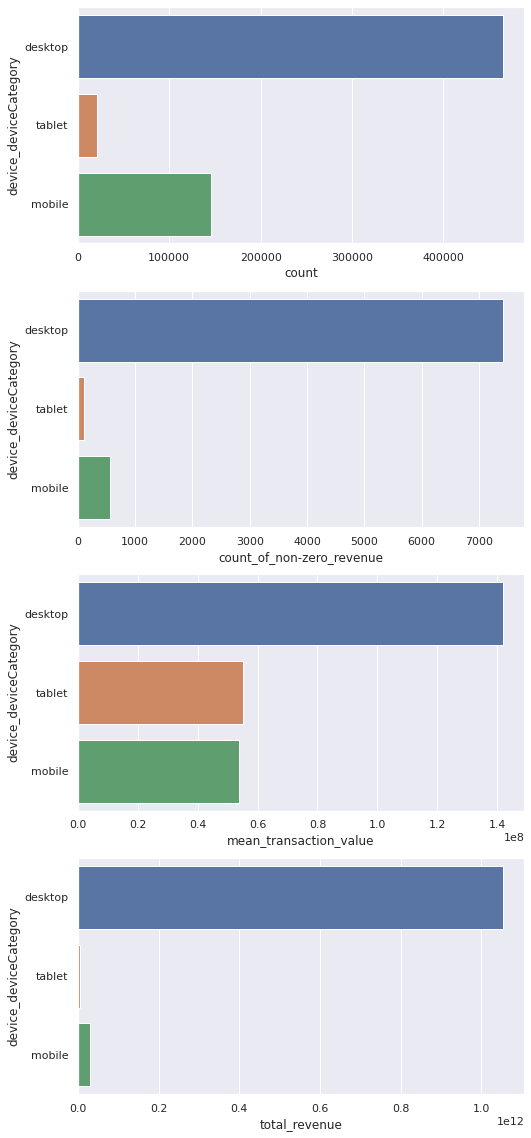

In [69]:
category_plots('device_deviceCategory')

Desktop users are more and do generate more revenue
In case of tablet and mobile users Mobile users are more
but both have comparable revenue

### Convert isMobile to bool from string

In [70]:
# here we are converting the "device.isMobile" data type from string to boolean.
train_date['device_isMobile']=   train_date['device_isMobile'].astype(bool)
test_date['device_isMobile']  = test_date['device_isMobile'].astype(bool)

## **Explore GeoNetwork Columns**

In [71]:
geo_cols = columns_extract('geoNetwork')
geo_cols

['geoNetwork_continent',
 'geoNetwork_subContinent',
 'geoNetwork_country',
 'geoNetwork_region',
 'geoNetwork_metro',
 'geoNetwork_city',
 'geoNetwork_networkDomain']

In [72]:
train_date[geo_cols].nunique(dropna = False)  

geoNetwork_continent            6
geoNetwork_subContinent        23
geoNetwork_country            219
geoNetwork_region             376
geoNetwork_metro               94
geoNetwork_city               649
geoNetwork_networkDomain    22823
dtype: int64

### GeoNetwork Continents


                       count  ...  total_revenue
geoNetwork_continent          ...               
Africa                 10238  ...   8.636800e+09
(not set)               1013  ...   5.997800e+08
Asia                  156165  ...   1.262741e+10
Oceania                10423  ...   1.749260e+09
Americas              315363  ...   1.062149e+12
Europe                138798  ...   4.444940e+09

[6 rows x 4 columns]


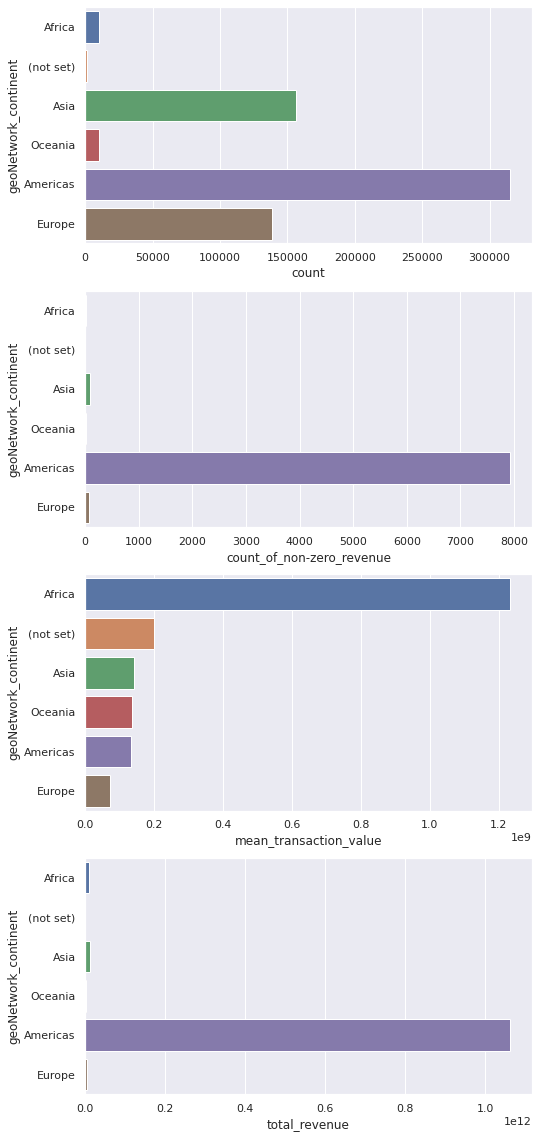

In [73]:
category_plots('geoNetwork_continent')


*   Though Asia and Europe has large number of users but revenue genetation is alot less
*   Americans are by far highest revenue Generators
*   Africans are less users but they have notably large mean transaction value
*   We can merge Oceanic and not set as both are similar





In [74]:
# Here we are just changing '(not set)' to 'UnknownContinent' for both test and training dataset
less_continent = ['(not set)']
train_date['geoNetwork_continent'] = train_date['geoNetwork_continent'].apply(lambda x: x if x not in less_continent else 'UnknownContinent')
test_date['geoNetwork_continent'] = test_date['geoNetwork_continent'].apply(lambda x: x if x not in less_continent else 'UnknownContinent')

In [75]:
train_date['geoNetwork_continent'].unique()

array(['Oceania', 'Americas', 'Asia', 'Africa', 'Europe',
       'UnknownContinent'], dtype=object)

### Explore sub Continent

                          count  ...  total_revenue
geoNetwork_subContinent          ...               
Eastern Africa             1330  ...   5.268700e+09
Western Africa             1771  ...   3.302400e+09
Eastern Asia              32782  ...   9.118040e+09
(not set)                  1013  ...   5.997800e+08
South America             29092  ...   8.934980e+09
Australasia               10316  ...   1.749260e+09
Northern America         273763  ...   1.050230e+12
Caribbean                  1659  ...   1.192750e+09
Southeast Asia            54268  ...   2.102030e+09
Central America           10849  ...   1.791540e+09

[10 rows x 4 columns]


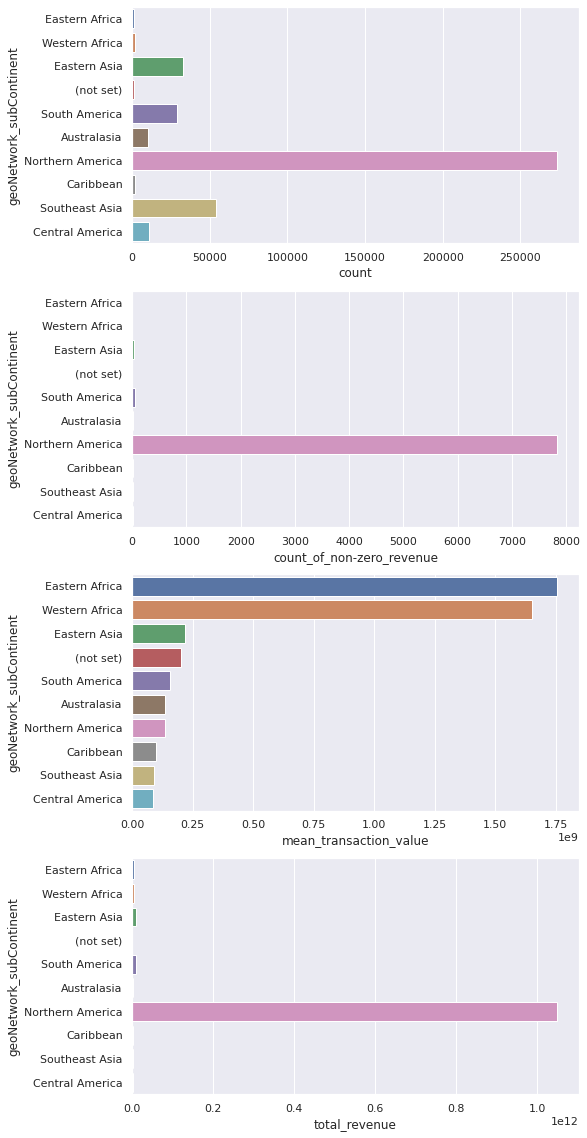

In [76]:
category_plots('geoNetwork_subContinent')

Except North America other subContinets have countable revenue generated

### Explore country

                    count  ...  total_revenue
geoNetwork_country         ...               
Kenya                 539  ...   5.268700e+09
Nigeria               997  ...   3.302400e+09
Japan               13747  ...   6.681120e+09
Portugal             1683  ...   2.158000e+08
Curaçao                24  ...   2.063300e+08
Ecuador               870  ...   6.179600e+08
Venezuela            1409  ...   6.726210e+09
(not set)            1013  ...   5.997800e+08
Canada              18162  ...   2.544659e+10
Malaysia             4495  ...   4.718500e+08

[10 rows x 4 columns]


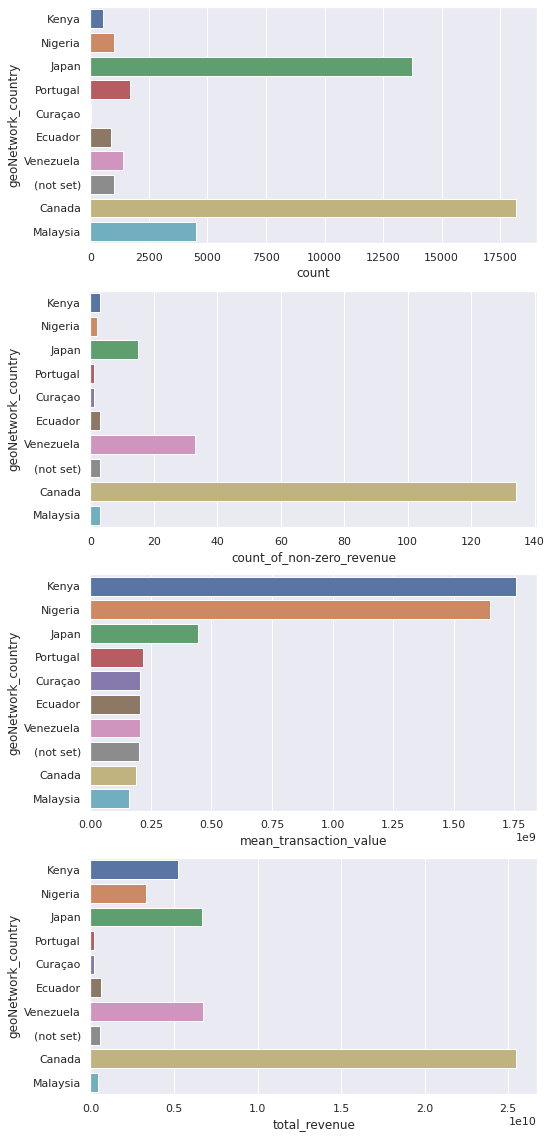

In [77]:
category_plots('geoNetwork_country')

### GeoNetwork Network Domain


In [78]:
train_date['geoNetwork_networkDomain'].nunique()


22823

                          count  ...  total_revenue
geoNetwork_networkDomain         ...               
digitalwest.net               6  ...   4.280700e+09
gfs.com                       8  ...   2.365500e+09
accesskenya.com              37  ...   1.999600e+09
directonpc.net                3  ...   1.794400e+09
ocn.ne.jp                  1638  ...   3.444770e+09
wananchi.com                 66  ...   3.269100e+09
dion.ne.jp                  213  ...   1.521510e+09
ipnxtelecoms.com             65  ...   1.508000e+09
as5580.net                  506  ...   1.462800e+09
wsd.net                       4  ...   1.272450e+09

[10 rows x 4 columns]


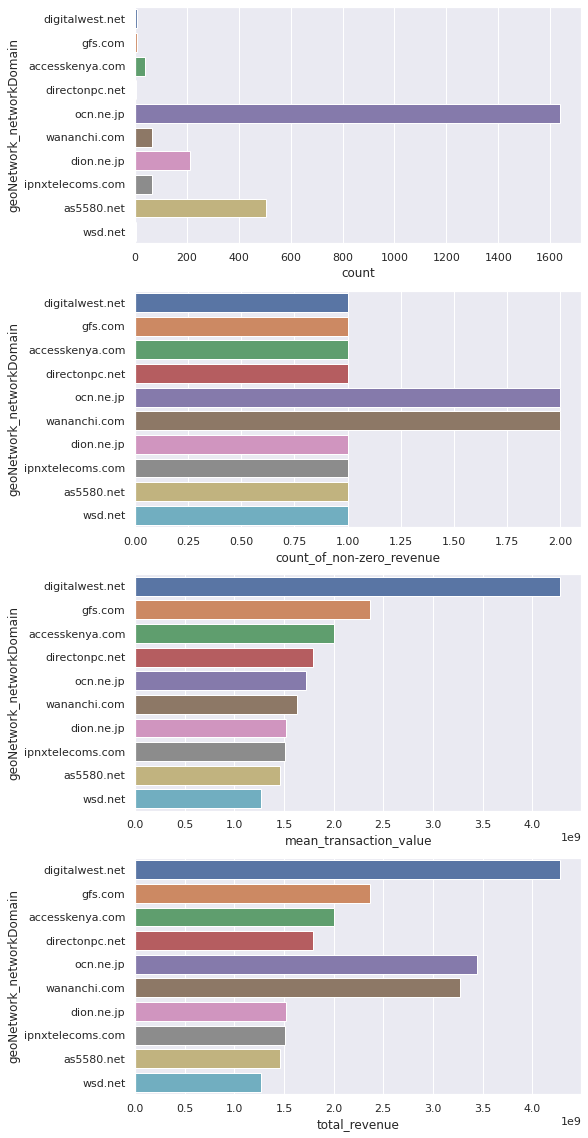

In [79]:
category_plots('geoNetwork_networkDomain')

since it has to many values we will reduce it

In [80]:
train_date['geoNetwork_networkDomain'].nunique()

22823

In [81]:
print(train_date['geoNetwork_networkDomain'].unique())

['xtra.co.nz' 'munitrujillo.gob.pe' 'comcast.net' ... 'ippf.org' 'ltam.lu'
 'wun.com.tw']


In [82]:
popular_networkDomain = train_date['geoNetwork_networkDomain'].value_counts()

In [83]:
#Taking out most popular 100 network domain
popular_networkDomain = popular_networkDomain[:100]

In [84]:
popular_networkDomain

(not set)           171183
unknown.unknown     102127
comcast.net          19916
rr.com               10521
verizon.net           9586
                     ...  
threembb.co.uk         543
plus.net               542
wideopenwest.com       540
otenet.gr              539
telekom.rs             536
Name: geoNetwork_networkDomain, Length: 100, dtype: int64

In [85]:
'''
Extracting top 100 Network Domains on basis of value counts and marking remaining as 'unpopular Network Domain' 
For both Test and Train datasets
'''
#train_date['geoNetwork_networkDomain'] = train_date['geoNetwork_networkDomain'].apply(lambda x: x if x in popular_networkDomain else 'unpopularND')
#test_date['geoNetwork_networkDomain'] = test_date['geoNetwork_networkDomain'].apply(lambda x: x if x in popular_networkDomain else 'unpopularND')

"\nExtracting top 100 Network Domains on basis of value counts and marking remaining as 'unpopular Network Domain' \nFor both Test and Train datasets\n"

In [86]:
train_date['geoNetwork_networkDomain'].nunique()

22823

In [87]:
train_date['geoNetwork_networkDomain'].unique()

array(['xtra.co.nz', 'munitrujillo.gob.pe', 'comcast.net', ...,
       'ippf.org', 'ltam.lu', 'wun.com.tw'], dtype=object)

## **Explore Total columns**

In [88]:
total_cols = columns_extract('totals')

In [89]:
train_date[total_cols].nunique(dropna=False)

totals_hits                   248
totals_pageviews              192
totals_newVisits                2
totals_bounces                  2
totals_transactionRevenue    4034
dtype: int64

**Explorable columns are totals.hits, totals.pageviews**

In [90]:
'''
Function to plot 4 types of barplots for each Totals column
1) Categories vs their counts
2) Categories vs Non-Zero Revenue
3) Categories vs Mean Transaction Revenue
4) Categories vs Total Reveue
'''
def total_col_plots(col):
    a = train_date.loc[:,[col, 'totals_transactionRevenue']]
    a['totals_transactionRevenue'] = a['totals_transactionRevenue'].replace(0.0, np.nan)
    cnt_srs = a.groupby(col)['totals_transactionRevenue'].agg(['size','count','mean'])
    cnt_srs.columns = ["count", 'count of non-zero revenue', "mean"]

    cnt_srs['total_revenue'] = cnt_srs['count of non-zero revenue']*cnt_srs['mean']
    cnt_srs = cnt_srs.sort_values(by="total_revenue", ascending=False)
    print(cnt_srs.head(10))
    plt.figure(figsize=(15, 20)) 
    plt.subplot(4,1,1)
    sns.barplot(y=cnt_srs['count'].head(50), x=list(range(1,51)))
    plt.subplot(4,1,2)
    sns.barplot(y=cnt_srs['count of non-zero revenue'].head(50), x=list(range(1,51)))
    plt.subplot(4,1,3)
    sns.barplot(y=cnt_srs['mean'].head(50), x=list(range(1,51)))
    plt.subplot(4,1,4)
    sns.barplot(y=cnt_srs['total_revenue'].head(50), x=list(range(1,51)))

### Totals Hits

             count  count of non-zero revenue          mean  total_revenue
totals_hits                                                               
17            2904                        269  1.234272e+08   3.320191e+10
58             133                         40  6.848318e+08   2.739327e+10
16            3298                        256  1.015748e+08   2.600315e+10
32             765                        141  1.799761e+08   2.537663e+10
19            2291                        240  1.005821e+08   2.413971e+10
91              37                         13  1.733926e+09   2.254104e+10
30             928                        177  1.229736e+08   2.176632e+10
34             587                        134  1.564147e+08   2.095957e+10
37             510                        121  1.720933e+08   2.082329e+10
26            1163                        188  1.080366e+08   2.031089e+10


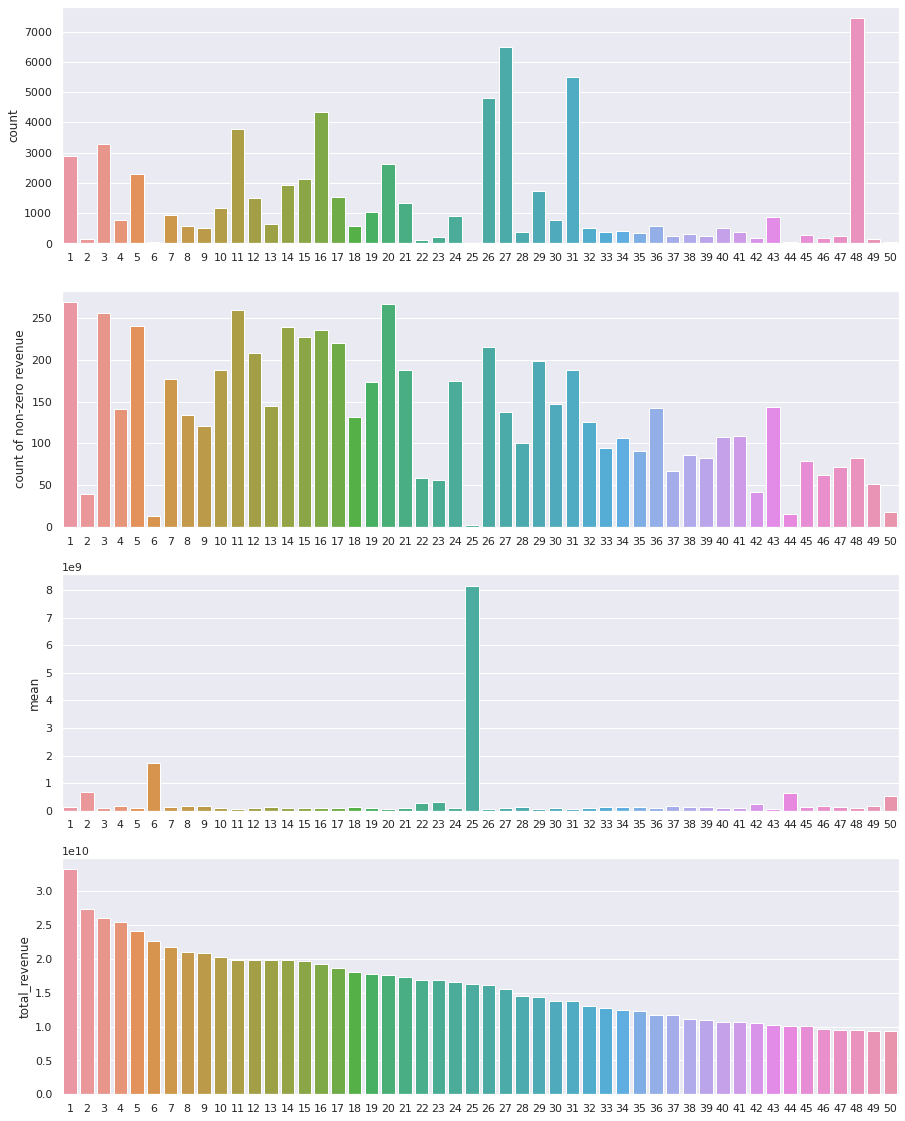

In [91]:
total_col_plots('totals_hits')

With increase in page hits revenue increases

###  Totals PageVies Section


                  count  count of non-zero revenue          mean  total_revenue
totals_pageviews                                                               
22                 1343                        245  1.611395e+08   3.947918e+10
14                 3792                        358  1.076977e+08   3.855578e+10
26                  930                        246  1.352174e+08   3.326349e+10
40                  247                         76  4.355122e+08   3.309893e+10
16                 2792                        324  9.798611e+07   3.174750e+10
21                 1539                        285  1.056640e+08   3.011425e+10
15                 3307                        344  8.688070e+07   2.988696e+10
18                 2225                        336  8.600765e+07   2.889857e+10
13                 4307                        320  8.550794e+07   2.736254e+10
17                 2398                        323  8.278833e+07   2.674063e+10


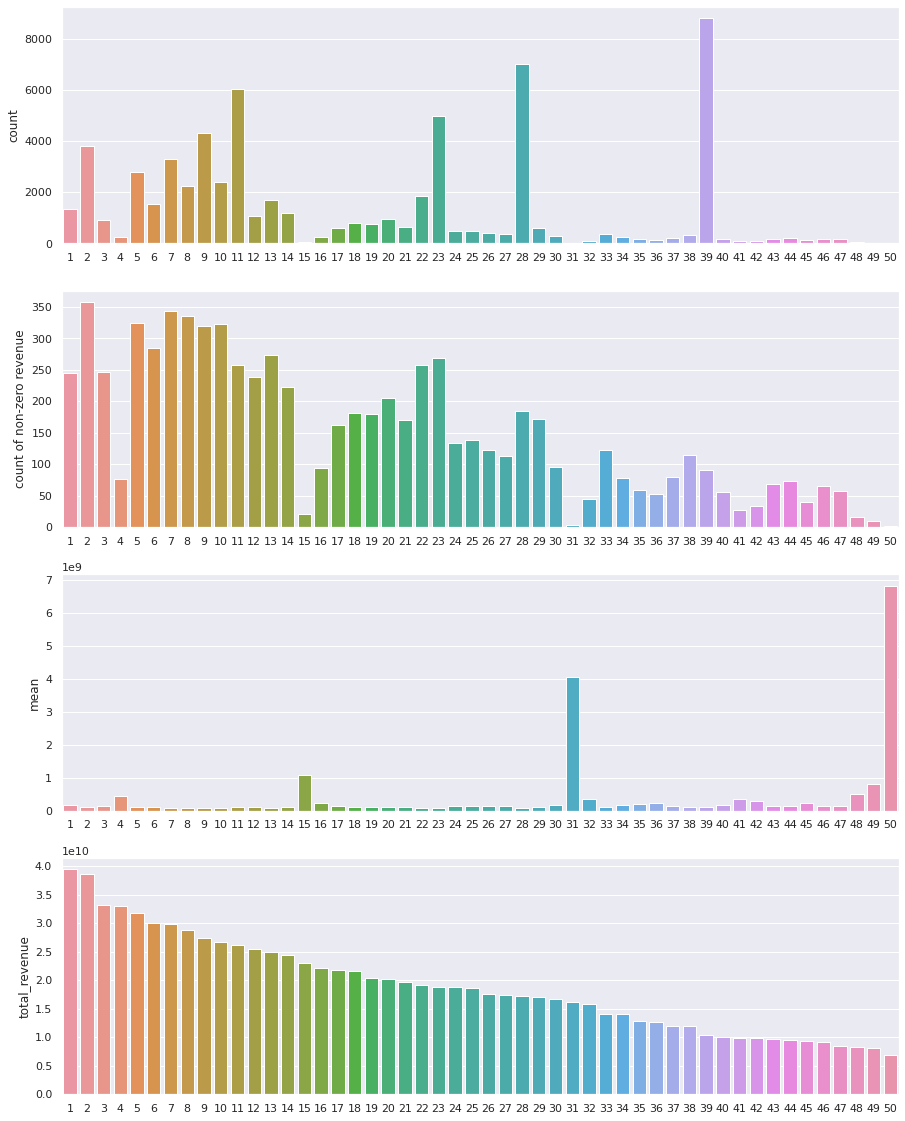

In [92]:
total_col_plots('totals_pageviews')

With increse in page view, revenue increases

## **Explore Tiraffic sourse analysis**

In [93]:
traffic_cols = columns_extract('trafficSource')

In [94]:
train_date[traffic_cols].nunique(dropna=False)

trafficSource_campaign                             10
trafficSource_source                              342
trafficSource_medium                                7
trafficSource_keyword                            2765
trafficSource_referralPath                       1258
trafficSource_isTrueDirect                          2
trafficSource_adwordsClickInfo.page                 9
trafficSource_adwordsClickInfo.slot                 3
trafficSource_adwordsClickInfo.gclId            12499
trafficSource_adwordsClickInfo.adNetworkType        3
trafficSource_adwordsClickInfo.isVideoAd            2
trafficSource_adContent                            42
dtype: int64

### Traffic Source Campaign

                                                  count  ...  total_revenue
trafficSource_campaign                                   ...               
(not set)                                        605213  ...   1.056355e+12
AW - Accessories                                   5021  ...   1.208493e+10
AW - Dynamic Search Ads Whole Site                10019  ...   2.110475e+10
Data Share Promo                                  11373  ...   5.973800e+08
test-liyuhz                                         246  ...   4.200000e+07
Retail (DO NOT EDIT owners nophakun and tianyu)      33  ...   2.295000e+07
AW - Apparel                                         33  ...            NaN
AW - Electronics                                     60  ...            NaN
All Products                                          1  ...            NaN
Data Share                                            1  ...            NaN

[10 rows x 4 columns]


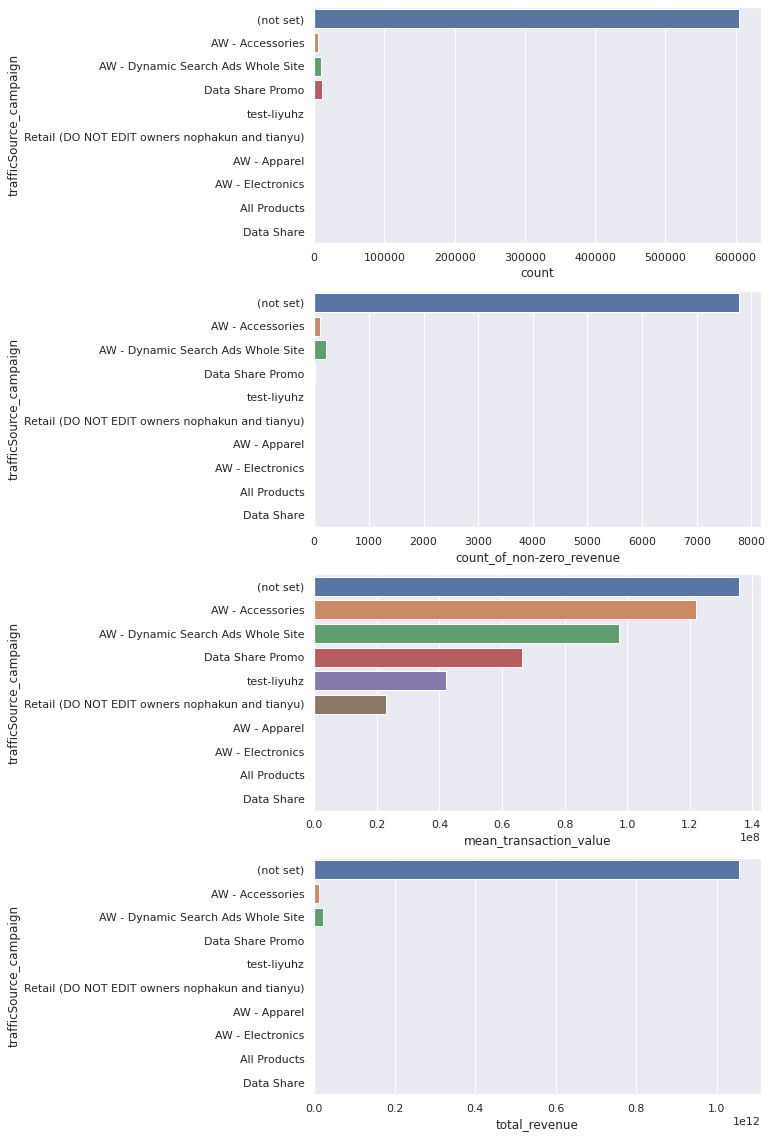

In [95]:
category_plots('trafficSource_campaign')

### Source

                            count  ...  total_revenue
trafficSource_source               ...               
dfa                          4041  ...   7.229700e+10
mail.google.com               986  ...   1.196387e+10
(direct)                   100309  ...   2.922202e+11
mg.mail.yahoo.com              16  ...   2.009500e+08
google.com                   3271  ...   2.639900e+08
sites.google.com             2065  ...   3.604880e+09
mall.googleplex.com         46361  ...   4.469263e+11
connect.googleforwork.com      71  ...   1.119800e+08
gdeals.googleplex.com         766  ...   1.276720e+09
google                     280272  ...   2.529956e+11

[10 rows x 4 columns]


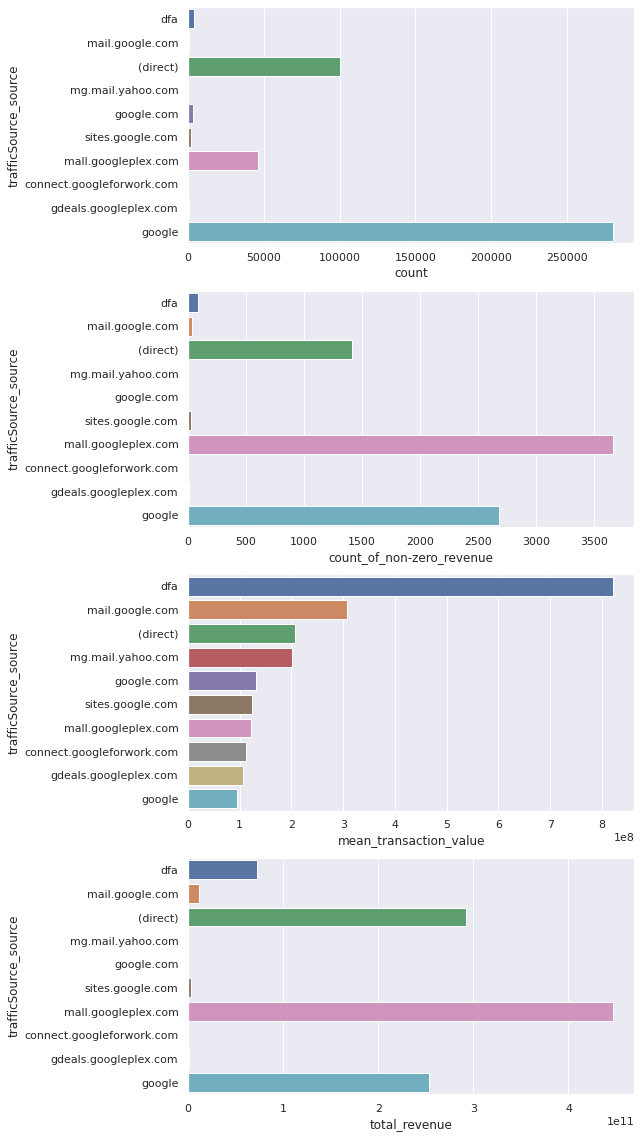

In [96]:
category_plots('trafficSource_source')

In [97]:
train_date['trafficSource_source'].unique()

array(['google', 'youtube.com', 'Partners', '(direct)', 'm.facebook.com',
       'mall.googleplex.com', 'sites.google.com', 'baidu', 'google.com',
       'yahoo', 'siliconvalley.about.com', 'productforums.google.com',
       'gdeals.googleplex.com', 'analytics.google.com', 'blog.golang.org',
       'phandroid.com', 'facebook.com', 'groups.google.com',
       'support.google.com', 'googleweblight.com', 'dfa', 't.co',
       'reddit.com', 'plus.google.com', 'quora.com', 'ask',
       '0.shared.bow.cat2.ads-bow.qk.borg.google.com:9873',
       '0.shared.bow.cat2.ads-bow.lf.borg.google.com:9860',
       '0.shared.bow.cat2.ads-bow.qk.borg.google.com:9846',
       '0.shared.bow.cat2.ads-bow.qk.borg.google.com:9885', 'qiita.com',
       'google.co.jp', 'optimize.google.com', 'connect.googleforwork.com',
       'bing', 'moma.corp.google.com', 'mail.google.com',
       'h.yandex-team.ru', 'l.facebook.com', 'dealspotr.com',
       'cases.corp.google.com', 'int.search.tb.ask.com', 'm.youtube.com'

In [98]:
def trafficSourcePopular(x):
    if  ('google' in x):
        return 'google'
    elif  ('youtube' in x):
        return 'youtube'
    elif '(not set)' in x or 'nan' in x:
        return x
    elif 'yahoo' in x:
        return 'yahoo'
    elif 'facebook' in x:
        return 'facebook'
    elif 'reddit' in x:
        return 'reddit'
    elif 'bing' in x:
        return 'bing'
    elif 'quora' in x:
        return 'quora'
    elif 'outlook' in x:
        return 'outlook'
    elif 'linkedin' in x:
        return 'linkedin'
    elif 'pinterest' in x:
        return 'pinterest'
    elif 'ask' in x:
        return 'ask'
    elif 'siliconvalley' in x:
        return 'siliconvalley'
    elif 'lunametrics' in x:
        return 'lunametrics'
    elif 'amazon' in x:
        return 'amazon'
    elif 'mysearch' in x:
        return 'mysearch'
    elif 'qiita' in x:
        return 'qiita'
    elif 'messenger' in x:
        return 'messenger'
    elif 'twitter' in x:
        return 'twitter'
    elif 't.co' in x:
        return 't.co'
    elif 'vk.com' in x:
        return 'vk.com'
    elif 'search' in x:
        return 'search'
    elif 'edu' in x:
        return 'edu'
    elif 'mail' in x:
        return 'mail'
    elif 'ad' in x:
        return 'ad'
    elif 'golang' in x:
        return 'golang'
    elif 'direct' in x:
        return 'direct'
    elif 'dealspotr' in x:
        return 'dealspotr'
    elif 'sashihara' in x:
        return 'sashihara'
    elif 'phandroid' in x:
        return 'phandroid'
    elif 'baidu' in x:
        return 'baidu'
    elif 'mdn' in x:
        return 'mdn'
    elif 'duckduckgo' in x:
        return 'duckduckgo'
    elif 'seroundtable' in x:
        return 'seroundtable'
    elif 'metrics' in x:
        return 'metrics'
    elif 'sogou' in x:
        return 'sogou'
    elif 'businessinsider' in x:
        return 'businessinsider'
    elif 'github' in x:
        return 'github'
    elif 'gophergala' in x:
        return 'gophergala'
    elif 'yandex' in x:
        return 'yandex'
    elif 'msn' in x:
        return 'msn'
    elif 'dfa' in x:
        return 'dfa'
    elif '(not set)' in x:
        return '(not set)'
    elif 'feedly' in x:
        return 'feedly'
    elif 'arstechnica' in x:
        return 'arstechnica'
    elif 'squishable' in x:
        return 'squishable'
    elif 'flipboard' in x:
        return 'flipboard'
    elif 't-online.de' in x:
        return 't-online.de'
    elif 'sm.cn' in x:
        return 'sm.cn'
    elif 'wow' in x:
        return 'wow'
    elif 'baidu' in x:
        return 'baidu'
    elif 'partners' in x:
        return 'partners'
    else:
        return 'others'

In [99]:
#train_date['trafficSource_source'] = train_date['trafficSource_source'].apply(lambda x: trafficSourcePopular(str(x).lower()))
#test_date['trafficSource_source'] = test_date['trafficSource_source'].apply(lambda x: trafficSourcePopular(str(x).lower()))

In [100]:
train_date['trafficSource_source'].nunique()

342

In [101]:
train_date['trafficSource_source'].unique()

array(['google', 'youtube.com', 'Partners', '(direct)', 'm.facebook.com',
       'mall.googleplex.com', 'sites.google.com', 'baidu', 'google.com',
       'yahoo', 'siliconvalley.about.com', 'productforums.google.com',
       'gdeals.googleplex.com', 'analytics.google.com', 'blog.golang.org',
       'phandroid.com', 'facebook.com', 'groups.google.com',
       'support.google.com', 'googleweblight.com', 'dfa', 't.co',
       'reddit.com', 'plus.google.com', 'quora.com', 'ask',
       '0.shared.bow.cat2.ads-bow.qk.borg.google.com:9873',
       '0.shared.bow.cat2.ads-bow.lf.borg.google.com:9860',
       '0.shared.bow.cat2.ads-bow.qk.borg.google.com:9846',
       '0.shared.bow.cat2.ads-bow.qk.borg.google.com:9885', 'qiita.com',
       'google.co.jp', 'optimize.google.com', 'connect.googleforwork.com',
       'bing', 'moma.corp.google.com', 'mail.google.com',
       'h.yandex-team.ru', 'l.facebook.com', 'dealspotr.com',
       'cases.corp.google.com', 'int.search.tb.ask.com', 'm.youtube.com'

### medium

                       count  ...  total_revenue
trafficSource_medium          ...               
cpm                     4451  ...   7.348485e+10
(none)                100307  ...   2.922202e+11
referral              231277  ...   4.704478e+11
cpc                    17927  ...   3.381967e+10
organic               266591  ...   2.196372e+11
affiliate              11374  ...   5.973800e+08
(not set)                 73  ...            NaN

[7 rows x 4 columns]


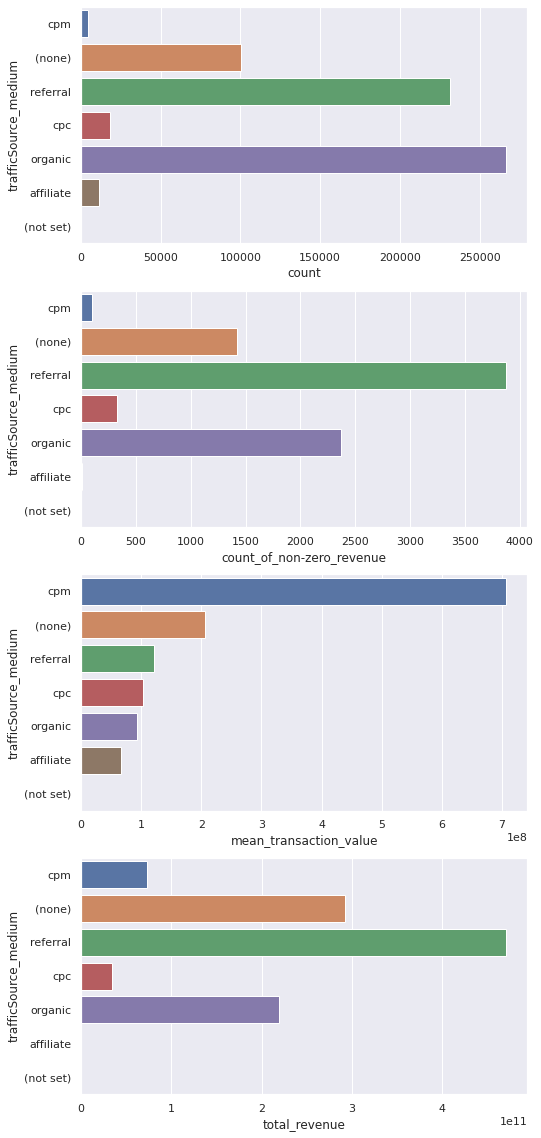

In [102]:
category_plots('trafficSource_medium')

In [103]:
train_date['trafficSource_medium'].unique()

array(['organic', 'referral', 'cpc', 'affiliate', '(none)', 'cpm',
       '(not set)'], dtype=object)

### adContent

                                 count  ...  total_revenue
trafficSource_adContent                 ...               
Google Merchandise Collection     3637  ...   1.190511e+10
Display Ad created 3/11/14         693  ...   1.959500e+08
Google Online Store                893  ...   1.129600e+08
Display Ad created 3/11/15         246  ...   4.200000e+07
Full auto ad IMAGE ONLY            644  ...   1.514400e+08
Display Ad created 11/17/14         33  ...   2.295000e+07
{KeyWord:Google Drinkware}          21  ...   1.495000e+07
Swag with Google Logos              40  ...   2.947000e+07
{KeyWord:Want Google Stickers?}     31  ...   2.244000e+07
20% discount                        56  ...            NaN

[10 rows x 4 columns]


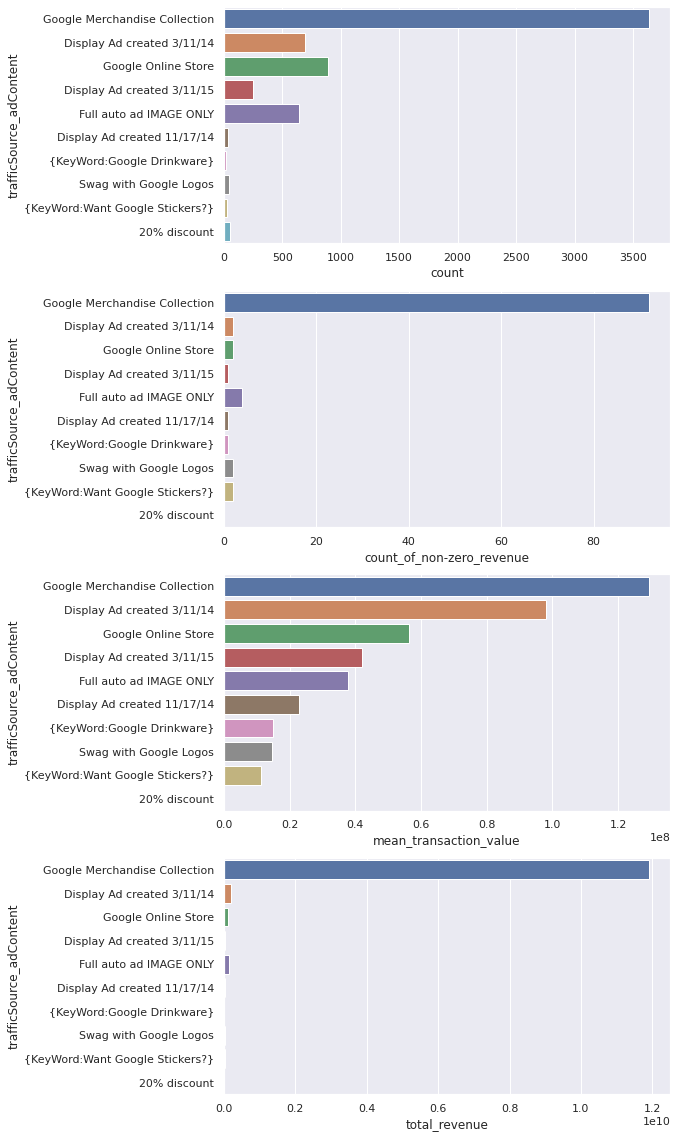

In [104]:
category_plots('trafficSource_adContent')

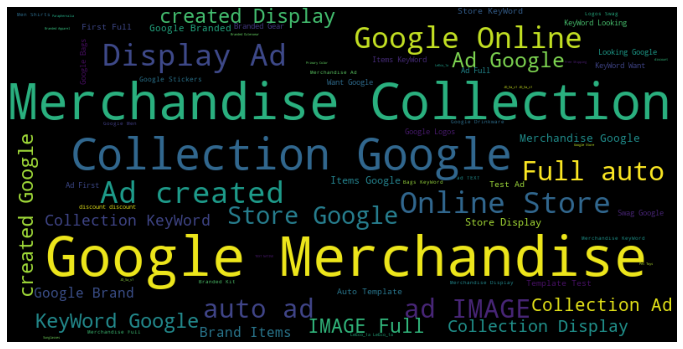

In [105]:
from wordcloud import WordCloud

ad_content = train_date['trafficSource_adContent'].fillna('')
wordcloud2 = WordCloud(width=800, height=400).generate(' '.join(ad_content))
plt.figure( figsize=(12,9))
plt.imshow(wordcloud2)
plt.axis("off")
plt.show()


In [106]:
train_date['trafficSource_adContent'].nunique()

41

In [107]:
train_date['trafficSource_adContent'].unique()

array([nan, 'Display Ad created 3/11/14', 'Google Merchandise Collection',
       'Full auto ad IMAGE ONLY', 'Display Ad created 3/11/15',
       '{KeyWord:Google Merchandise}', 'Google Online Store',
       'Ad from 11/3/16', '{KeyWord:Google Brand Items}',
       'Ad from 12/13/16', 'Google Merchandise',
       '{KeyWord:Want Google Stickers?}', '{KeyWord:Google Branded Gear}',
       '20% discount', '{KeyWord:Looking for Google Bags?}',
       'Display Ad created 11/17/14', 'Ad from 11/7/16',
       '{KeyWord:Google Branded Kit}', 'Full auto ad TEXT/NATIVE',
       '{KeyWord:Google Drinkware}', 'Swag with Google Logos',
       'Free Shipping!', 'Google Paraphernalia', 'LeEco_1a',
       'Ad from 2/17/17', "{KeyWord:Google Men's T-Shirts}",
       '{KeyWord:Want Google Pet Toys?}', 'Google Store',
       'Full auto ad TEXT ONLY', 'First Full Auto Template Test Ad',
       '{KeyWord:Google Branded Outerwear}', 'Want Google Sunglasses',
       'JD_5a_v1', '{KeyWord:Google Branded Appar

In [108]:
'''
Funtion to get more revenue generating ads and combining unpopular one
But it is not used considering the fact each ad is different
'''
def popular_adContent(x):
    if  ('google' in x):
        return 'google'
    elif  ('placement' in x) | ('placememnt' in x):
        return 'placement'
    elif '(not set)' in x or 'nan' in x:
        return x
    elif 'ad' in x:
        return x
    else:
        return 'others'

In [109]:
#train_date['trafficSource_adContent'] = train_date['trafficSource_adContent'].apply(lambda x: popular_adContent(str(x).lower()))
#test_date['trafficSource_adContent'] = test_date['trafficSource_adContent'].apply(lambda x: popular_adContent(str(x).lower()))

In [110]:
train_date['trafficSource_adContent'].unique()

array([nan, 'Display Ad created 3/11/14', 'Google Merchandise Collection',
       'Full auto ad IMAGE ONLY', 'Display Ad created 3/11/15',
       '{KeyWord:Google Merchandise}', 'Google Online Store',
       'Ad from 11/3/16', '{KeyWord:Google Brand Items}',
       'Ad from 12/13/16', 'Google Merchandise',
       '{KeyWord:Want Google Stickers?}', '{KeyWord:Google Branded Gear}',
       '20% discount', '{KeyWord:Looking for Google Bags?}',
       'Display Ad created 11/17/14', 'Ad from 11/7/16',
       '{KeyWord:Google Branded Kit}', 'Full auto ad TEXT/NATIVE',
       '{KeyWord:Google Drinkware}', 'Swag with Google Logos',
       'Free Shipping!', 'Google Paraphernalia', 'LeEco_1a',
       'Ad from 2/17/17', "{KeyWord:Google Men's T-Shirts}",
       '{KeyWord:Want Google Pet Toys?}', 'Google Store',
       'Full auto ad TEXT ONLY', 'First Full Auto Template Test Ad',
       '{KeyWord:Google Branded Outerwear}', 'Want Google Sunglasses',
       'JD_5a_v1', '{KeyWord:Google Branded Appar

### Keyword

                              count  ...  total_revenue
trafficSource_keyword                ...               
googlesupport                     6  ...   4.168000e+08
googlemerchandisestore           10  ...   2.164300e+08
+Google +Merchandise            231  ...   1.007340e+09
Google Merchandise             1181  ...   5.563960e+09
google merchandise store       1545  ...   5.067720e+09
+google +merchandise +store     183  ...   2.228400e+08
6qEhsCssdK0z36ri               8099  ...   1.799400e+10
(not provided)               255876  ...   2.175071e+11
youtube merchandise store        12  ...   7.693000e+07
+google +merch                   56  ...   7.499000e+07

[10 rows x 4 columns]


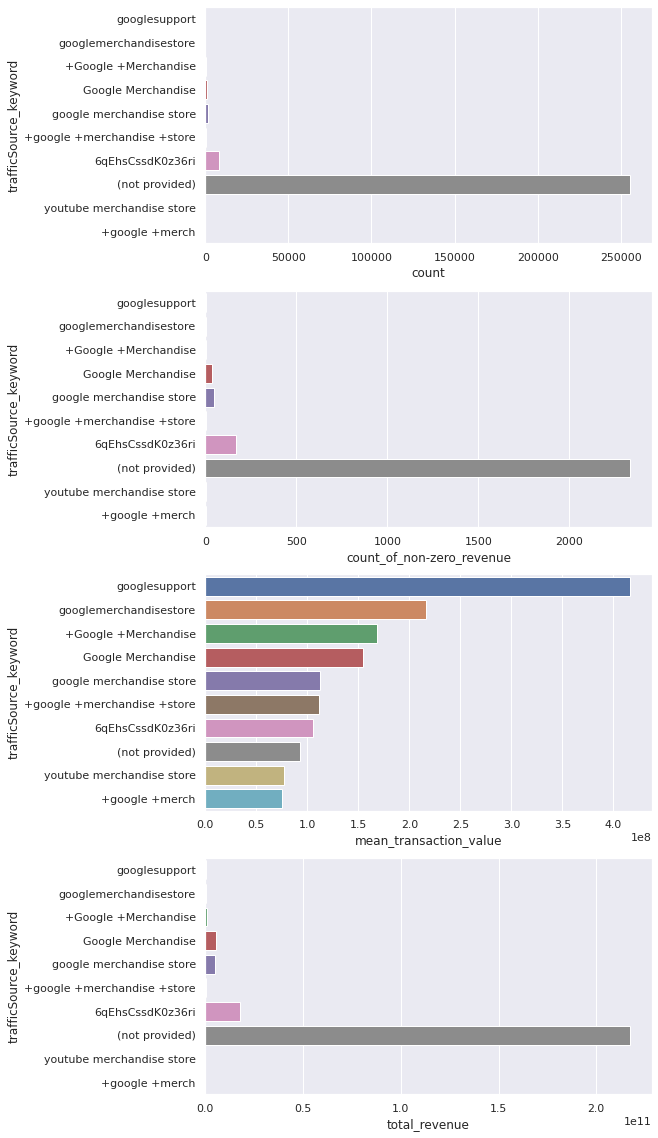

In [111]:
category_plots('trafficSource_keyword')

### referral Path

                                                    count  ...  total_revenue
trafficSource_referralPath                                 ...               
/mail/u/0/                                            706  ...   1.167130e+10
/neo/launch                                            14  ...   2.009500e+08
/a/google.com/googletopia/discounts-deals-and-f...    756  ...   1.568640e+09
/permissions/using-the-logo.html                     3034  ...   2.639900e+08
/a/google.com/google-merchandise-store/on-site-...    390  ...   1.049870e+09
/a/google.com/google-merchandise-store/on-site-...    342  ...   7.796800e+08
/                                                   52702  ...   4.485701e+11
/external-link.jspa                                    60  ...   1.119800e+08
/a/google.com/another-attempt-google-merchandis...      3  ...   1.084500e+08
/offer/2145                                           767  ...   1.276720e+09

[10 rows x 4 columns]


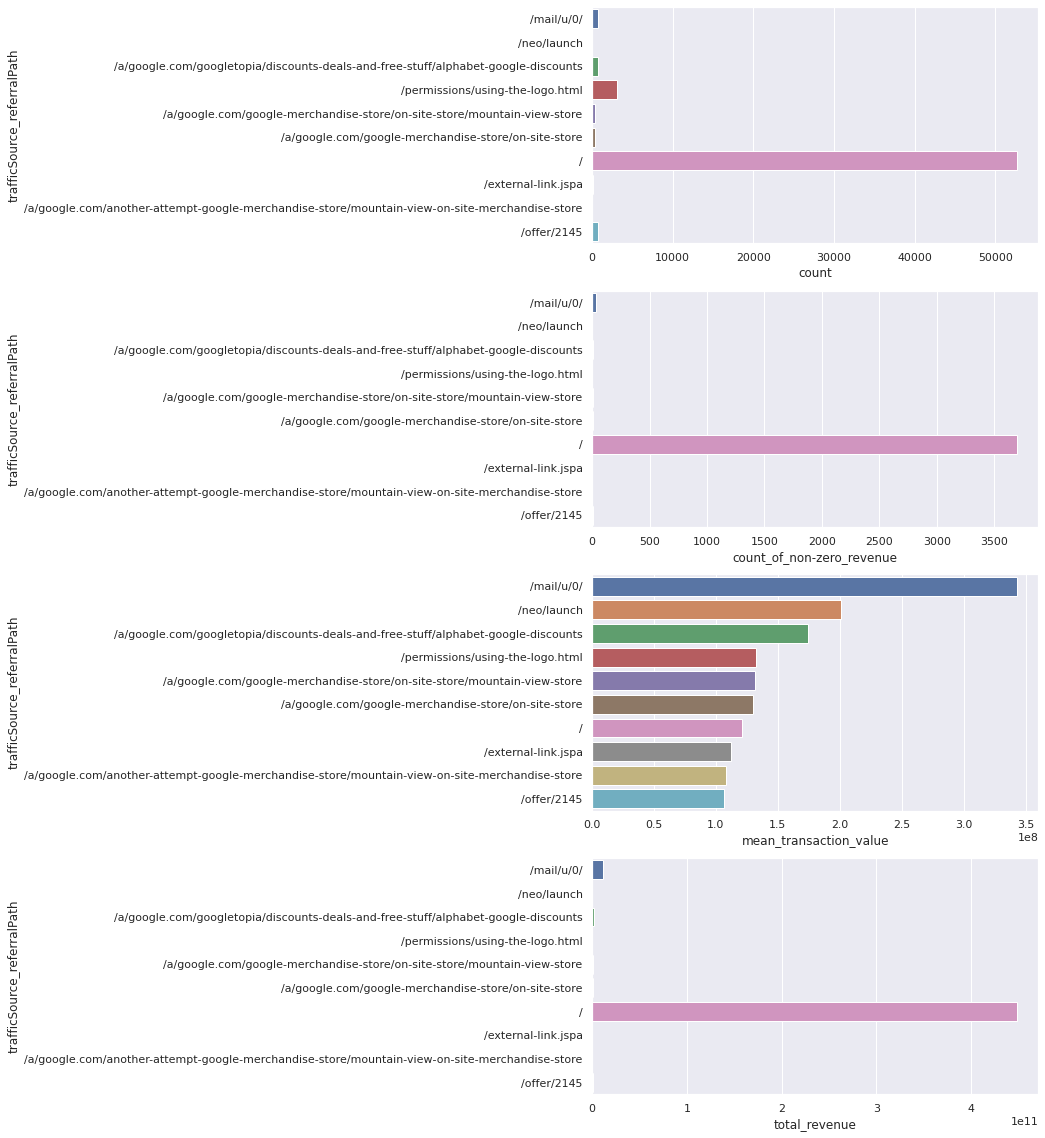

In [112]:
category_plots('trafficSource_referralPath')

In [113]:
revenue_generators = ['/', '/yt/about/']

In [114]:
#train_date['trafficSource_referralPath'] = train_date['trafficSource_referralPath'].apply(lambda x : x if x in revenue_generators else 'other')
#test_date['trafficSource_referralPath'] = test_date['trafficSource_referralPath'].apply(lambda x : x if x in revenue_generators else 'other')


In [115]:
train_date.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 632000 entries, 0 to 631999
Data columns (total 40 columns):
 #   Column                                        Non-Null Count   Dtype         
---  ------                                        --------------   -----         
 0   channelGrouping                               632000 non-null  object        
 1   date                                          632000 non-null  datetime64[ns]
 2   fullVisitorId                                 632000 non-null  object        
 3   sessionId                                     632000 non-null  object        
 4   visitId                                       632000 non-null  int64         
 5   visitNumber                                   632000 non-null  int64         
 6   visitStartTime                                632000 non-null  int64         
 7   device_browser                                632000 non-null  object        
 8   device_operatingSystem                        632000 n

# Split categorical and Numerical Columns

In [116]:
categorical_cols = list()
for i in train_date.columns:
    if (train_date[i].dtype=='object' or train_date[i].dtype=='bool') and (not(i.startswith('total'))):
        categorical_cols.append(i)

In [117]:
len(categorical_cols)

26

In [118]:
train_date[categorical_cols].nunique(dropna=False)

channelGrouping                                      8
fullVisitorId                                   499358
sessionId                                       631378
device_browser                                      22
device_operatingSystem                              11
device_isMobile                                      2
device_deviceCategory                                3
geoNetwork_continent                                 6
geoNetwork_subContinent                             23
geoNetwork_country                                 219
geoNetwork_region                                  376
geoNetwork_metro                                    94
geoNetwork_city                                    649
geoNetwork_networkDomain                         22823
trafficSource_campaign                              10
trafficSource_source                               342
trafficSource_medium                                 7
trafficSource_keyword                             2765
trafficSou

Numerical columns

In [119]:
numerical_cols = list()
for c in train_date.columns:
    if train_date[c].dtype not in ['object', 'bool']:
        numerical_cols.append(c)

In [120]:
train_date[numerical_cols].nunique(dropna = False)

date                            366
visitId                      623240
visitNumber                     384
visitStartTime               623851
totals_transactionRevenue      4034
_weekday                          7
_day                             31
_month                           12
_year                             2
_visitHour                       24
dtype: int64

Remove fullvisitor ID, session ID before lable encoding

In [121]:
categorical_cols.remove('fullVisitorId')
categorical_cols.remove('sessionId')

Delete columns which are of no use

In [122]:
numerical_cols.remove('date')
numerical_cols.remove('visitId')
numerical_cols.remove('visitStartTime')
#numerical_cols.remove('_year')

In [123]:
numerical_cols

['visitNumber',
 'totals_transactionRevenue',
 '_weekday',
 '_day',
 '_month',
 '_year',
 '_visitHour']

In [124]:
len(numerical_cols) + len(categorical_cols)

31

Check remaining columns

In [125]:
set(train_date.columns)-set(numerical_cols + categorical_cols)

{'date',
 'fullVisitorId',
 'sessionId',
 'totals_bounces',
 'totals_hits',
 'totals_newVisits',
 'totals_pageviews',
 'visitId',
 'visitStartTime'}

In [126]:
numerical_cols.append('totals_bounces')
numerical_cols.append('totals_hits')
numerical_cols.append('totals_newVisits')
numerical_cols.append('totals_pageviews')

In [127]:
#numerical_cols.remove('totals_bounces')
#numerical_cols.remove('totals_newVisits')

In [128]:
numerical_cols

['visitNumber',
 'totals_transactionRevenue',
 '_weekday',
 '_day',
 '_month',
 '_year',
 '_visitHour',
 'totals_bounces',
 'totals_hits',
 'totals_newVisits',
 'totals_pageviews']

# Mising Value Treatment

First lets do for numerical columns

In [129]:
train_date[numerical_cols].isnull().sum()

visitNumber                       0
totals_transactionRevenue         0
_weekday                          0
_day                              0
_month                            0
_year                             0
_visitHour                        0
totals_bounces               316642
totals_hits                       0
totals_newVisits             140503
totals_pageviews                 69
dtype: int64

In [130]:
test_date[numerical_cols].isnull().sum()

visitNumber                       0
totals_transactionRevenue         0
_weekday                          0
_day                              0
_month                            0
_year                             0
_visitHour                        0
totals_bounces               136381
totals_hits                       0
totals_newVisits              60090
totals_pageviews                 31
dtype: int64

In [131]:
train_date['totals_bounces'].unique()

array([nan, '1'], dtype=object)

In [132]:
train_date['totals_newVisits'].unique()

array(['1', nan], dtype=object)

In [133]:
train_date['totals_bounces'] = train_date['totals_bounces'].fillna(0)
test_date['totals_bounces'] = test_date['totals_bounces'].fillna(0)

train_date['totals_newVisits'] = train_date['totals_newVisits'].fillna(0)
test_date['totals_newVisits'] = test_date['totals_newVisits'].fillna(0)

train_date['totals_pageviews'] = train_date['totals_pageviews'].fillna(1)
test_date['totals_pageviews'] = test_date['totals_pageviews'].fillna(1)

In [134]:
train_date[numerical_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 632000 entries, 0 to 631999
Data columns (total 11 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   visitNumber                632000 non-null  int64  
 1   totals_transactionRevenue  632000 non-null  float64
 2   _weekday                   632000 non-null  int64  
 3   _day                       632000 non-null  int64  
 4   _month                     632000 non-null  int64  
 5   _year                      632000 non-null  int64  
 6   _visitHour                 632000 non-null  int64  
 7   totals_bounces             632000 non-null  object 
 8   totals_hits                632000 non-null  object 
 9   totals_newVisits           632000 non-null  object 
 10  totals_pageviews           632000 non-null  object 
dtypes: float64(1), int64(6), object(4)
memory usage: 53.0+ MB


In [135]:
for col in ['totals_hits','totals_pageviews', 'totals_bounces', 'totals_newVisits' ]:
    train_date[col] = train_date[col].astype(int)
    test_date[col] = test_date[col].astype(int)

In [136]:
train_date[numerical_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 632000 entries, 0 to 631999
Data columns (total 11 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   visitNumber                632000 non-null  int64  
 1   totals_transactionRevenue  632000 non-null  float64
 2   _weekday                   632000 non-null  int64  
 3   _day                       632000 non-null  int64  
 4   _month                     632000 non-null  int64  
 5   _year                      632000 non-null  int64  
 6   _visitHour                 632000 non-null  int64  
 7   totals_bounces             632000 non-null  int64  
 8   totals_hits                632000 non-null  int64  
 9   totals_newVisits           632000 non-null  int64  
 10  totals_pageviews           632000 non-null  int64  
dtypes: float64(1), int64(10)
memory usage: 53.0 MB


Missing values in categorical columns

In [137]:
mv = train_date[categorical_cols].isnull().sum()
mp = mv / len(train_date)*100
mp

channelGrouping                                  0.000000
device_browser                                   0.000000
device_operatingSystem                           0.000000
device_isMobile                                  0.000000
device_deviceCategory                            0.000000
geoNetwork_continent                             0.000000
geoNetwork_subContinent                          0.000000
geoNetwork_country                               0.000000
geoNetwork_region                                0.000000
geoNetwork_metro                                 0.000000
geoNetwork_city                                  0.000000
geoNetwork_networkDomain                         0.000000
trafficSource_campaign                           0.000000
trafficSource_source                             0.000000
trafficSource_medium                             0.000000
trafficSource_keyword                           55.677373
trafficSource_referralPath                      63.407437
trafficSource_

In [138]:
mvt = test_date[categorical_cols].isnull().sum()
mpt = mvt / len(test_date)*100
mpt 

channelGrouping                                  0.000000
device_browser                                   0.000000
device_operatingSystem                           0.000000
device_isMobile                                  0.000000
device_deviceCategory                            0.000000
geoNetwork_continent                             0.000000
geoNetwork_subContinent                          0.000000
geoNetwork_country                               0.000000
geoNetwork_region                                0.000000
geoNetwork_metro                                 0.000000
geoNetwork_city                                  0.000000
geoNetwork_networkDomain                         0.000000
trafficSource_campaign                           0.000000
trafficSource_source                             0.000000
trafficSource_medium                             0.000000
trafficSource_keyword                           55.603288
trafficSource_referralPath                      63.307602
trafficSource_

percent of missing values in each categorical columns

In [139]:
train_date.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 632000 entries, 0 to 631999
Data columns (total 40 columns):
 #   Column                                        Non-Null Count   Dtype         
---  ------                                        --------------   -----         
 0   channelGrouping                               632000 non-null  object        
 1   date                                          632000 non-null  datetime64[ns]
 2   fullVisitorId                                 632000 non-null  object        
 3   sessionId                                     632000 non-null  object        
 4   visitId                                       632000 non-null  int64         
 5   visitNumber                                   632000 non-null  int64         
 6   visitStartTime                                632000 non-null  int64         
 7   device_browser                                632000 non-null  object        
 8   device_operatingSystem                        632000 n

In [140]:
test_date.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271653 entries, 0 to 271652
Data columns (total 40 columns):
 #   Column                                        Non-Null Count   Dtype         
---  ------                                        --------------   -----         
 0   channelGrouping                               271653 non-null  object        
 1   date                                          271653 non-null  datetime64[ns]
 2   fullVisitorId                                 271653 non-null  object        
 3   sessionId                                     271653 non-null  object        
 4   visitId                                       271653 non-null  int64         
 5   visitNumber                                   271653 non-null  int64         
 6   visitStartTime                                271653 non-null  int64         
 7   device_browser                                271653 non-null  object        
 8   device_operatingSystem                        271653 n

In [141]:
#Filling missing values
for col in ['trafficSource_keyword',
            'trafficSource_referralPath',
            'trafficSource_adContent',
            'trafficSource_adwordsClickInfo.page',
            'trafficSource_adwordsClickInfo.slot',
            'trafficSource_adwordsClickInfo.gclId',
            'trafficSource_adwordsClickInfo.adNetworkType',
            'trafficSource_isTrueDirect',
            'trafficSource_adwordsClickInfo.isVideoAd']:
    train_date[col].fillna('unknown', inplace=True)
    test_date[col].fillna('unknown', inplace=True)

check for any null value remaining

In [142]:
train_date.isnull().sum()

channelGrouping                                 0
date                                            0
fullVisitorId                                   0
sessionId                                       0
visitId                                         0
visitNumber                                     0
visitStartTime                                  0
device_browser                                  0
device_operatingSystem                          0
device_isMobile                                 0
device_deviceCategory                           0
geoNetwork_continent                            0
geoNetwork_subContinent                         0
geoNetwork_country                              0
geoNetwork_region                               0
geoNetwork_metro                                0
geoNetwork_city                                 0
geoNetwork_networkDomain                        0
totals_hits                                     0
totals_pageviews                                0


In [143]:
train_date.shape

(632000, 40)

In [144]:
test_date.shape

(271653, 40)

In [145]:
train_date.isnull().sum()

channelGrouping                                 0
date                                            0
fullVisitorId                                   0
sessionId                                       0
visitId                                         0
visitNumber                                     0
visitStartTime                                  0
device_browser                                  0
device_operatingSystem                          0
device_isMobile                                 0
device_deviceCategory                           0
geoNetwork_continent                            0
geoNetwork_subContinent                         0
geoNetwork_country                              0
geoNetwork_region                               0
geoNetwork_metro                                0
geoNetwork_city                                 0
geoNetwork_networkDomain                        0
totals_hits                                     0
totals_pageviews                                0


In [146]:
train_date.head()

,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,device_browser,device_operatingSystem,device_isMobile,device_deviceCategory,geoNetwork_continent,geoNetwork_subContinent,geoNetwork_country,geoNetwork_region,geoNetwork_metro,geoNetwork_city,geoNetwork_networkDomain,totals_hits,totals_pageviews,totals_newVisits,totals_bounces,totals_transactionRevenue,trafficSource_campaign,trafficSource_source,trafficSource_medium,trafficSource_keyword,trafficSource_referralPath,trafficSource_isTrueDirect,trafficSource_adwordsClickInfo.page,trafficSource_adwordsClickInfo.slot,trafficSource_adwordsClickInfo.gclId,trafficSource_adwordsClickInfo.adNetworkType,trafficSource_adwordsClickInfo.isVideoAd,trafficSource_adContent,_weekday,_day,_month,_year,_visitHour
0,Organic Search,2016-10-20,0000010278554503158,0000010278554503158_1477029466,1477029466,1,1477029466,chrome,macintosh,False,desktop,Oceania,Australasia,New Zealand,not available in demo dataset,not available in demo dataset,not available in demo dataset,xtra.co.nz,11,8,1,0,0.0,(not set),google,organic,(not provided),unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,3,20,10,2016,5
1,Organic Search,2016-11-30,0000020424342248747,0000020424342248747_1480578901,1480578901,1,1480578901,chrome,windows,False,desktop,Americas,South America,Peru,Lima Region,(not set),La Victoria,munitrujillo.gob.pe,17,13,1,0,0.0,(not set),google,organic,(not provided),unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,2,30,11,2016,7
2,Organic Search,2017-02-11,0000027376579751715,0000027376579751715_1486866293,1486866293,1,1486866293,chrome,macintosh,False,desktop,Americas,Northern America,United States,not available in demo dataset,not available in demo dataset,not available in demo dataset,comcast.net,6,5,1,0,0.0,(not set),google,organic,(not provided),unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,5,11,2,2017,2
3,Social,2017-03-27,0000039460501403861,0000039460501403861_1490629516,1490629516,1,1490629516,chrome,windows,False,desktop,Americas,South America,Brazil,not available in demo dataset,not available in demo dataset,not available in demo dataset,virtua.com.br,2,2,1,0,0.0,(not set),youtube.com,referral,unknown,/yt/about/pt-BR/,unknown,unknown,unknown,unknown,unknown,unknown,unknown,0,27,3,2017,15
4,Paid Search,2017-02-11,0000040862739425590,0000040862739425590_1486838824,1486838824,2,1486838824,chrome,macintosh,False,desktop,Americas,Northern America,United States,California,San Francisco-Oakland-San Jose CA,Oakland,comcastbusiness.net,3,3,0,0,0.0,AW - Dynamic Search Ads Whole Site,google,cpc,1hZbAqLCbjwfgOH7,unknown,True,1,Top,Cj0KEQiAifvEBRCVx5up6Ojgr5oBEiQALHw1TrnWAHiMtZ...,Google Search,False,unknown,5,11,2,2017,18


# Feature engineering of Total Hits and pageviews

In [147]:
train_date['mean_hits_per_networkDomain'] = train_date.groupby('geoNetwork_networkDomain')['totals_hits'].transform('mean').astype('int')
train_date['mean_pageViews_per_networkDomain'] = train_date.groupby('geoNetwork_networkDomain')['totals_pageviews'].transform('mean').astype('int')

In [148]:
test_date['mean_hits_per_networkDomain'] = test_date.groupby('geoNetwork_networkDomain')['totals_hits'].transform('mean').astype('int')
test_date['mean_pageViews_per_networkDomain'] = test_date.groupby('geoNetwork_networkDomain')['totals_pageviews'].transform('mean').astype('int')


In [149]:
numerical_cols.append('mean_pageViews_per_networkDomain')
numerical_cols.append('mean_hits_per_networkDomain')

In [150]:
train_date.head()

,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,device_browser,device_operatingSystem,device_isMobile,device_deviceCategory,geoNetwork_continent,geoNetwork_subContinent,geoNetwork_country,geoNetwork_region,geoNetwork_metro,geoNetwork_city,geoNetwork_networkDomain,totals_hits,totals_pageviews,totals_newVisits,totals_bounces,totals_transactionRevenue,trafficSource_campaign,trafficSource_source,trafficSource_medium,trafficSource_keyword,trafficSource_referralPath,trafficSource_isTrueDirect,trafficSource_adwordsClickInfo.page,trafficSource_adwordsClickInfo.slot,trafficSource_adwordsClickInfo.gclId,trafficSource_adwordsClickInfo.adNetworkType,trafficSource_adwordsClickInfo.isVideoAd,trafficSource_adContent,_weekday,_day,_month,_year,_visitHour,mean_hits_per_networkDomain,mean_pageViews_per_networkDomain
0,Organic Search,2016-10-20,0000010278554503158,0000010278554503158_1477029466,1477029466,1,1477029466,chrome,macintosh,False,desktop,Oceania,Australasia,New Zealand,not available in demo dataset,not available in demo dataset,not available in demo dataset,xtra.co.nz,11,8,1,0,0.0,(not set),google,organic,(not provided),unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,3,20,10,2016,5,3,3
1,Organic Search,2016-11-30,0000020424342248747,0000020424342248747_1480578901,1480578901,1,1480578901,chrome,windows,False,desktop,Americas,South America,Peru,Lima Region,(not set),La Victoria,munitrujillo.gob.pe,17,13,1,0,0.0,(not set),google,organic,(not provided),unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,2,30,11,2016,7,17,13
2,Organic Search,2017-02-11,0000027376579751715,0000027376579751715_1486866293,1486866293,1,1486866293,chrome,macintosh,False,desktop,Americas,Northern America,United States,not available in demo dataset,not available in demo dataset,not available in demo dataset,comcast.net,6,5,1,0,0.0,(not set),google,organic,(not provided),unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,5,11,2,2017,2,7,6
3,Social,2017-03-27,0000039460501403861,0000039460501403861_1490629516,1490629516,1,1490629516,chrome,windows,False,desktop,Americas,South America,Brazil,not available in demo dataset,not available in demo dataset,not available in demo dataset,virtua.com.br,2,2,1,0,0.0,(not set),youtube.com,referral,unknown,/yt/about/pt-BR/,unknown,unknown,unknown,unknown,unknown,unknown,unknown,0,27,3,2017,15,2,2
4,Paid Search,2017-02-11,0000040862739425590,0000040862739425590_1486838824,1486838824,2,1486838824,chrome,macintosh,False,desktop,Americas,Northern America,United States,California,San Francisco-Oakland-San Jose CA,Oakland,comcastbusiness.net,3,3,0,0,0.0,AW - Dynamic Search Ads Whole Site,google,cpc,1hZbAqLCbjwfgOH7,unknown,True,1,Top,Cj0KEQiAifvEBRCVx5up6Ojgr5oBEiQALHw1TrnWAHiMtZ...,Google Search,False,unknown,5,11,2,2017,18,7,6


# Label Encoding categorical columns

In [151]:
#train_copy = train_date.copy()
#test_copy = test_date.copy()

In [152]:
! pip install feature_engine

     |████████████████████████████████| 9.5MB 7.0MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [153]:
'''
from feature_engine import categorical_encoders as ce
# set up the encoder
encoder = ce.CountFrequencyCategoricalEncoder(encoding_method='frequency', variables = categorical_cols)

# fit the encoder
encoder.fit(train_date)

# transform the data
train_date = encoder.transform(train_date)
test_date = encoder.transform(test_date)

encoder.encoder_dict_
for col in categorical_cols:
    print("transform column {}".format(col))
    lbe = LabelEncoder()
    lbe.fit(pd.concat([train_date[col], test_date[col]]).astype("str"))
    train_date[col] = lbe.transform(train_date[col].astype("str"))
    test_date[col] = lbe.transform(test_date[col].astype("str"))
    

for col in categorical_cols:
    print("transform column {}".format(col))
    encoder = ce.CountFrequencyCategoricalEncoder(encoding_method='frequency', variables = col)
    # fit the encoder
    encoder.fit(pd.concat([train_date[col], test_date[col]]).astype("str"))
    train_date[col] = encoder.transform(train_date[col].astype("str"))
    test_date[col] = encoder.transform(test_date[col].astype("str"))
    
'''

'\nfrom feature_engine import categorical_encoders as ce\n# set up the encoder\nencoder = ce.CountFrequencyCategoricalEncoder(encoding_method=\'frequency\', variables = categorical_cols)\n\n# fit the encoder\nencoder.fit(train_date)\n\n# transform the data\ntrain_date = encoder.transform(train_date)\ntest_date = encoder.transform(test_date)\n\nencoder.encoder_dict_\nfor col in categorical_cols:\n    print("transform column {}".format(col))\n    lbe = LabelEncoder()\n    lbe.fit(pd.concat([train_date[col], test_date[col]]).astype("str"))\n    train_date[col] = lbe.transform(train_date[col].astype("str"))\n    test_date[col] = lbe.transform(test_date[col].astype("str"))\n    \n\nfor col in categorical_cols:\n    print("transform column {}".format(col))\n    encoder = ce.CountFrequencyCategoricalEncoder(encoding_method=\'frequency\', variables = col)\n    # fit the encoder\n    encoder.fit(pd.concat([train_date[col], test_date[col]]).astype("str"))\n    train_date[col] = encoder.transform

In [154]:
print(type(train_date))

<class 'pandas.core.frame.DataFrame'>


In [155]:
#target = train_date['totals_transactionRevenue']
def frequencyencoding(df,cols):
  #frequency encoding 
  for col in cols:   
    newcol=col
    df[newcol]=df.groupby(col)[col].transform('count')
    df[newcol]=(df[newcol]-df[newcol].min())/(df[newcol].max()-df[newcol].min())
    #tenco=pd.DataFrame()
    #tenco['totals_transactionRevenue']=target
    #target encoding
  return(df)

In [156]:
train_date = frequencyencoding(train_date, categorical_cols)

In [157]:
from feature_engine import categorical_encoders as ce

for col in categorical_cols:
    print("transform column {}".format(col))
    encoder = ce.CountFrequencyCategoricalEncoder(encoding_method='frequency', variables = col)
    # fit the encoder
    print(type(train_date[col]))
    encoder.fit((pd.concat([train_date[col], test_date[col]]).astype("str")).to_frame() )
    train_date[col] = encoder.transform(train_date[col].astype("str"))
    test_date[col] = encoder.transform(test_date[col].astype("str"))

transform column channelGrouping
<class 'pandas.core.series.Series'>


TypeError: ignored

In [ ]:
train_date.info()

In [ ]:
train_date.head()

In [ ]:
from sklearn.preprocessing import LabelEncoder
for col in categorical_cols:
    print("transform column {}".format(col))
    lbe = LabelEncoder()
    lbe.fit(pd.concat([train_date[col], test_date[col]]).astype("str"))
    train_date[col] = lbe.transform(train_date[col].astype("str"))
    test_date[col] = lbe.transform(test_date[col].astype("str"))

In [ ]:
train_date.head()

In [ ]:
test_date.head()

In [ ]:
print(train_date.shape, test_date.shape)

Remove total_transactionRevenue column from numerical columns as it is to be predicted

In [ ]:
numerical_cols.remove('totals_transactionRevenue')

In [ ]:
#training columns
train_X = train_date[categorical_cols+numerical_cols]
# target column
train_Y = train_date['totals_transactionRevenue']

In [ ]:
#test dataset same columns
test_X = test_date[categorical_cols+numerical_cols]

In [ ]:
print(categorical_cols + numerical_cols)

In [ ]:
train_X.columns

### test


In [ ]:
train_date['date'].describe()

In [ ]:
'''
# Split the train dataset into development and valid based on time
from datetime import date 
dev_df = train_date[train_date['date'].dt.date <= date(2017,5,3)]
val_df = train_date[train_date['date'].dt.date > date(2017,5,3)]
dev_y = np.log1p(dev_df["totals_transactionRevenue"].values)
val_y = np.log1p(val_df["totals_transactionRevenue"].values)

dev_X = dev_df[categorical_cols + numerical_cols] 
val_X = val_df[categorical_cols + numerical_cols] 
test_X = test_date[categorical_cols + numerical_cols]
'''

In [ ]:
# Split the train dataset into development and valid based on time
dev_df = train_date
dev_y = np.log1p(dev_df["totals_transactionRevenue"].values)

dev_X = dev_df[categorical_cols + numerical_cols] 
test_X = test_date[categorical_cols + numerical_cols]

In [ ]:
train_date

### **GroupKfold + LightGBM**

In [ ]:
# custom function to run light gbm model
def kfold_lightgbm(df_x,df_y,test, num_folds, stratified = False, debug= False):
    print('GroupKFold + LGBM')
    
    # Divide in training/validation and test data
    train_df = df_x
    test_df = test
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    del df_x
    gc.collect()
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns ]
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], df_y)):
        train_x, train_y = train_df[feats].iloc[train_idx], df_y[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], df_y[valid_idx]
        print('\n Fold : ', n_fold+1)
        # LightGBM parameters found by Bayesian optimization
        clf = LGBMRegressor(
            objective = "regression",
            metric = "rmse", 
            num_leaves = 40,
            min_child_samples = 100,
            learning_rate = 0.005,
            bagging_fraction = 0.85,
            feature_fraction = 0.8,
            bagging_frequency = 6,
            bagging_seed = 42,
            verbosity = -1 )

        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
            eval_metric= 'rmse', verbose= 1000, early_stopping_rounds= 500)

        oof_preds[valid_idx] = clf.predict(valid_x, num_iteration=clf.best_iteration_)
        sub_preds += clf.predict(test_df[feats], num_iteration=clf.best_iteration_) / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d RMSE : %.6f' % (n_fold + 1, mean_squared_error(valid_y, oof_preds[valid_idx])))
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    print('Full RMSE score %.6f' % mean_squared_error(df_y, oof_preds))
    # Write submission file and plot feature importance
#    if not debug:
#        test_df['TARGET'] = sub_preds
#        test_df[['SK_ID_CURR', 'TARGET']].to_csv(submission_file_name, index= False)
#    display_importances(feature_importance_df)
    return sub_preds

In [ ]:
# Training the model #dev_X = dev_df[categorical_cols + numerical_cols] 

#dev_X = train_date[categorical_cols + numerical_cols] 
#dev_y = np.log1p(train_date['totals_transactionRevenue'].values)
#test_X = test_date[categorical_cols + numerical_cols]

pred_test = kfold_lightgbm(dev_X, dev_y, test_X, 6)

In [ ]:
#create submission
def createSub(test_id,pred_test):
    sub_df = pd.DataFrame({"fullVisitorId":test_id})
    pred_test[pred_test<0] = 0
    sub_df["PredictedLogRevenue"] = np.expm1(pred_test)
    sub_df = sub_df.groupby("fullVisitorId")["PredictedLogRevenue"].sum().reset_index()
    sub_df.columns = ["fullVisitorId", "PredictedLogRevenue"]
    sub_df["PredictedLogRevenue"] = np.log1p(sub_df["PredictedLogRevenue"])
    sub_df.to_csv("KFold_lgb.csv", index=False)

In [ ]:
test_id = test_date["fullVisitorId"].values
    #create submission
createSub(test_id,pred_test)
from google.colab import files
files.download("KFold_lgb.csv")

Make proper datasets Train and validation

In [ ]:
# Split the train dataset into development and valid based on time

dev_df = train_date[train_date['date'].dt.date <= date(2017,5,3)]
val_df = train_date[train_date['date'].dt.date > date(2017,5,3)]
dev_y = np.log1p(dev_df["totals_transactionRevenue"].values)
val_y = np.log1p(val_df["totals_transactionRevenue"].values)

dev_X = dev_df[categorical_cols + numerical_cols] 
val_X = val_df[categorical_cols + numerical_cols] 
test_X = test_date[categorical_cols + numerical_cols]

## LGBM

In [ ]:
# custom function to run light gbm model
import lightgbm as lgb
def run_lgb(train_X, train_y, val_X, val_y, test_X):
    params = {
        "objective" : "regression",
        "metric" : "rmse", 
        "num_leaves" : 40,
        "num_threads" : 10,
        "min_child_samples" : 100,
        "learning_rate" : 0.005,
        "bagging_fraction" : 0.95,
        "feature_fraction" : 0.85,
        "bagging_frequency" : 6,
        "bagging_seed" : 42,
        "verbosity" : -1
    }
    
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    model = lgb.train(params, lgtrain, 10000, valid_sets=[lgval], early_stopping_rounds=500, verbose_eval=500)
    
    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    pred_val_y = model.predict(val_X, num_iteration=model.best_iteration)
    return pred_test_y, model, pred_val_y

# Training the model #
pred_test, model, pred_val = run_lgb(dev_X, dev_y, val_X, val_y, test_X)

In [ ]:
from sklearn import metrics
pred_val[pred_val<0] = 0
val_pred_df = pd.DataFrame({"fullVisitorId":val_df["fullVisitorId"].values})
val_pred_df["transactionRevenue"] = val_df["totals_transactionRevenue"].values
val_pred_df["PredictedRevenue"] = np.expm1(pred_val)
#print(np.sqrt(metrics.mean_squared_error(np.log1p(val_pred_df["transactionRevenue"].values), np.log1p(val_pred_df["PredictedRevenue"].values))))
val_pred_df = val_pred_df.groupby("fullVisitorId")["transactionRevenue", "PredictedRevenue"].sum().reset_index()
print(np.sqrt(metrics.mean_squared_error(np.log1p(val_pred_df["transactionRevenue"].values), np.log1p(val_pred_df["PredictedRevenue"].values))))

In [ ]:
test_id = test_date["fullVisitorId"].values

In [ ]:
sub_df = pd.DataFrame({"fullVisitorId":test_id})
pred_test[pred_test<0] = 0
sub_df["PredictedLogRevenue"] = np.expm1(pred_test)
sub_df = sub_df.groupby("fullVisitorId")["PredictedLogRevenue"].sum().reset_index()
sub_df.columns = ["fullVisitorId", "PredictedLogRevenue"]
sub_df["PredictedLogRevenue"] = np.log1p(sub_df["PredictedLogRevenue"])
sub_df.to_csv("baseline_lgb2.csv", index=False)

In [ ]:
sub_df.head()

In [ ]:
fig, ax = plt.subplots(figsize=(12,18))
lgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()


## **XGBOOST**

In [ ]:
import xgboost as xgb

In [ ]:
def run_xgb(X_train, y_train, X_val, y_val, X_test):
    params = {'objective': 'reg:linear',
              'eval_metric': 'RMSE',
              'eta': 0.001,
              'max_depth': 10,
              'subsample': 0.6,
              'colsample_bytree': 0.6,
              'alpha':0.001,
              'random_state': 42,
              'silent': True}

    xgb_train_data = xgb.DMatrix(X_train, y_train)
    xgb_val_data = xgb.DMatrix(X_val, y_val)
    xgb_submit_data = xgb.DMatrix(X_test)

    model = xgb.train(params, xgb_train_data, 
                      num_boost_round=2000, 
                      evals= [(xgb_train_data, 'train'), (xgb_val_data, 'valid')],
                      early_stopping_rounds=100, 
                      verbose_eval=500
                     )

    y_pred_train = model.predict(xgb_train_data, ntree_limit=model.best_ntree_limit)
    y_pred_val = model.predict(xgb_val_data, ntree_limit=model.best_ntree_limit)
    y_pred_submit = model.predict(xgb_submit_data, ntree_limit=model.best_ntree_limit)

    return y_pred_submit, model

In [ ]:
%%time
# SKIP XGB as it takes very much time

# Train XGBoost and generate predictions

#xgb_preds, xgb_model = run_xgb(dev_X, dev_y, val_X, val_y, test_X)

## **CATBOOST**

In [ ]:
!pip install catboost

In [ ]:
from catboost import CatBoostRegressor

In [ ]:
def run_catboost(X_train, y_train, X_val, y_val, X_test):
    model = CatBoostRegressor(iterations=5000,
                             learning_rate=0.01,
                             depth=10,
                             eval_metric='RMSE',
                             random_seed = 42,
                             bagging_temperature = 0.6,
                             od_type='Iter',
                             metric_period = 300,
                             od_wait=150,
                              use_best_model = True)
    model.fit(X_train, y_train,
              eval_set=(X_val, y_val),
              use_best_model=True,
              verbose=True)
    
    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_val)
    y_pred_submit = model.predict(X_test)

    return y_pred_submit, model

In [ ]:
%%time
# Train Catboost and generate predictions
cat_preds, cat_model = run_catboost(dev_X, dev_y, val_X, val_y, test_X)

In [ ]:
# negative values are made zero
pred_test[pred_test<0] = 0
cat_preds[cat_preds<0] = 0
print(pred_test)
print(cat_preds)

In [ ]:
# create a dataframe with test's id and target
test_date = pd.DataFrame({"fullVisitorId":test_date["fullVisitorId"].values})

# convert log to exp form for all model predictions
test_date["PredictedRevenue_lgb"] = np.expm1(pred_test)

#test_date["PredictedRevenue_xgb"] = np.expm1(xgb_preds)

test_date["PredictedRevenue_cgb"] = np.expm1(cat_preds)

print(test_date["PredictedRevenue_lgb"])
print(test_date["PredictedRevenue_cgb"])

In [ ]:
# find sum of transaction revenue of each user
test_date = test_date.groupby("fullVisitorId")["PredictedRevenue_lgb", "PredictedRevenue_cgb"].sum().reset_index()
len(test_date)

In [ ]:
test_date['PredictedRevenue_lgb_log'] = test_date['PredictedRevenue_lgb'].apply(np.log1p)
test_date['PredictedRevenue_cgb_log'] = test_date['PredictedRevenue_cgb'].apply(np.log1p)


In [ ]:
ensemble_preds_new= 0.0 * test_date['PredictedRevenue_lgb_log'] + 1.00 * test_date['PredictedRevenue_cgb_log'] 
test_date['ensemble_preds_new'] = ensemble_preds_new
sub_df_3 = pd.DataFrame()
sub_df_3['fullVisitorId'] = test_date['fullVisitorId']
sub_df_3['PredictedLogRevenue'] = test_date['ensemble_preds_new']
sub_df_3.to_csv('submission_cat.csv', index=False)

In [ ]:
from google.colab import files
files.download("submission_cat.csv")

##Model Ensembling

### LightGBM * 0.7 + CatBoost * 0.3

In [ ]:
ensemble_preds_new= 0.70 * test_date['PredictedRevenue_lgb_log'] + 0.30 * test_date['PredictedRevenue_cgb_log'] 
test_date['ensemble_preds_new'] = ensemble_preds_new
sub_df_1 = pd.DataFrame()
sub_df_1['fullVisitorId'] = test_date['fullVisitorId']
sub_df_1['PredictedLogRevenue'] = test_date['ensemble_preds_new']
sub_df_1.to_csv('ensemble_submission_1.csv', index=False)

In [ ]:
from google.colab import files
files.download("ensemble_submission_1.csv")

### LightGBM * 0.5 + CatBoost * 0.5

In [ ]:
ensemble_preds_new= 0.50 * test_date['PredictedRevenue_lgb_log'] + 0.50 * test_date['PredictedRevenue_cgb_log'] 
test_date['ensemble_preds_new'] = ensemble_preds_new
sub_df_1 = pd.DataFrame()
sub_df_1['fullVisitorId'] = test_date['fullVisitorId']
sub_df_1['PredictedLogRevenue'] = test_date['ensemble_preds_new']
sub_df_1.to_csv('ensemble_submission_2.csv', index=False)

In [ ]:
sub_df_1

In [ ]:
from google.colab import files
files.download("ensemble_submission_2.csv")

## Using Stratified KFold with XGB algorithm

In [ ]:
skf = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)
skf.get_n_splits(train_ids, y_train)
xgb_test_result_1  = np.zeros(test_ids.shape[0])
oof_1= np.zeros(train_ids.shape[0])

counter = 0

print('\nXGBoost\n')

for train_index, test_index in skf.split(train_ids, y_train):
    
    print('Fold {}'.format(counter + 1))
    
    train = load_npz('train.npz')
    X_fit = vstack([train[train_index[i*m:(i+1)*m]] for i in range(train_index.shape[0] // m + 1)])
    X_val = vstack([train[test_index[i*m:(i+1)*m]]  for i in range(test_index.shape[0] //  m + 1)])
    X_fit, X_val = csr_matrix(X_fit, dtype='float32'), csr_matrix(X_val, dtype='float32')
    y_fit, y_val = y_train[train_index], y_train[test_index]
    
    
    del train
    gc.collect()

    xgb_model = xgb.XGBClassifier(learning_rate=0.025, 
                            n_estimators=3000, 
                            max_depth=13,
                            min_child_weight=9,
                            gamma=0.2,
                            subsample=1,
                            colsample_bytree=0.4,
                            objective= 'binary:logistic',
                            nthread=-1,
                            scale_pos_weight=1,
                            reg_alpha = 0.6,
                            reg_lambda = 3,
                            seed=42)
                               
    xgb_model.fit(X_fit, y_fit, eval_metric='auc', 
                  eval_set=[(X_val, y_val)], 
                  verbose=500, early_stopping_rounds=500)
                  
    oof_1[test_index] += xgb_model.predict_proba(X_val)[:,1]
    
    del X_fit, X_val, y_fit, y_val, train_index, test_index
    gc.collect()
    
    test = load_npz('test.npz')
    test = csr_matrix(test, dtype='float32')
    xgb_test_result_1 += xgb_model.predict_proba(test)[:,1]
    counter += 1
    
    del test
    gc.collect()

Stratified K Fold

In [ ]:
def get_folds(df=None, n_splits=5):
    """Returns dataframe indices corresponding to Visitors stratified KFold"""
    # Get sorted unique visitors
    unique_vis = np.array(sorted(df['fullVisitorId'].unique()))

    # Get folds
    folds = StratifiedKFold(n_splits=n_splits)
    fold_ids = []
    ids = np.arange(df.shape[0])
    for trn_vis, val_vis in folds.split(X=unique_vis, y=unique_vis, groups=unique_vis):
        fold_ids.append(
            [
                ids[df['fullVisitorId'].isin(unique_vis[trn_vis])],
                ids[df['fullVisitorId'].isin(unique_vis[val_vis])]
            ]
        )

    return fold_ids
